In [1]:
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')

import numpy as np
import pandas as pd
import scanpy.api as sc

import os

In [2]:
%matplotlib inline

In [3]:
CUR_DIR = os.getcwd()
ROOT = os.path.dirname(os.path.dirname(CUR_DIR))

In [4]:
def load_10x_scanpy(path, batch_label):
    sc01 = sc.read('{}/matrix.mtx'.format(path), cache=True).T
    sc01.var_names = pd.read_table('{}/genes.tsv'.format(path), header=None)[1]
    sc01.obs_names = pd.read_table('{}/barcodes.tsv'.format(path), header=None)[0]
    sc01.obs_names = sc01.obs_names.str.replace('-1', '')
    sc01.var_names_make_unique()
    sc.pp.filter_cells(sc01, min_genes=200)
    sc.pp.filter_genes(sc01, min_cells=3)

    mito_genes = sc01.var_names[sc01.var_names.str.match(r'^mt-')]
    sc01.obs['n_UMI'] = np.sum(sc01.X, axis=1).A1
    sc01.obs['percent_mito'] = np.sum(sc01[:, mito_genes].X, axis=1).A1 / sc01.obs['n_UMI']

    assgn = pd.read_csv('{}/{}_assgn.csv'.format(
        os.path.join(CUR_DIR, '..', '01-cluster-sc01-sc02'),
        batch_label,
    ), index_col=0)
    assgn.columns = ['cluster']

    sc01.obs['cluster'] = assgn.cluster[sc01.obs.index]
    return sc01

In [5]:
sc01 = load_10x_scanpy(os.path.join(ROOT, 'SC01'), 'SC01')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
clusters = pd.read_csv(os.path.join(CUR_DIR, 'MCA_clusters.csv'))
sc01p = pd.read_csv('./sc01-best-preds.csv', index_col=0)
sc01p.index = sc01p.index.str.replace('-1', '')
sc01p.columns = clusters.Annotation

In [22]:
sc01p.drop(sc01p.index[~sc01p.index.isin(sc01.obs.index)], inplace=True)

In [23]:
preds = sc01p.idxmax(axis=1)
pred_scores = sc01p.max(axis=1)

In [30]:
import seaborn
from matplotlib import pyplot as plt

In [53]:
def violin(df, x, y, title, xticklabels=None):
    plt.figure(figsize=(25, 10))
    seaborn.stripplot(x=x, y=y, data=df, jitter=True, alpha=0.4, color="black", size=2)
    ax = seaborn.violinplot(x=x, y=y, data=df, inner=None)
    if xticklabels:
        ax.set_xticklabels(xticklabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)
    plt.tight_layout()
    ax.figure.savefig('./sc01-{}.png'.format(y))
    return ax

In [65]:
df = sc01.obs.copy()

In [66]:
df['prediction'] = preds[df.index]

In [67]:
df['pred_score'] = pred_scores[df.index]

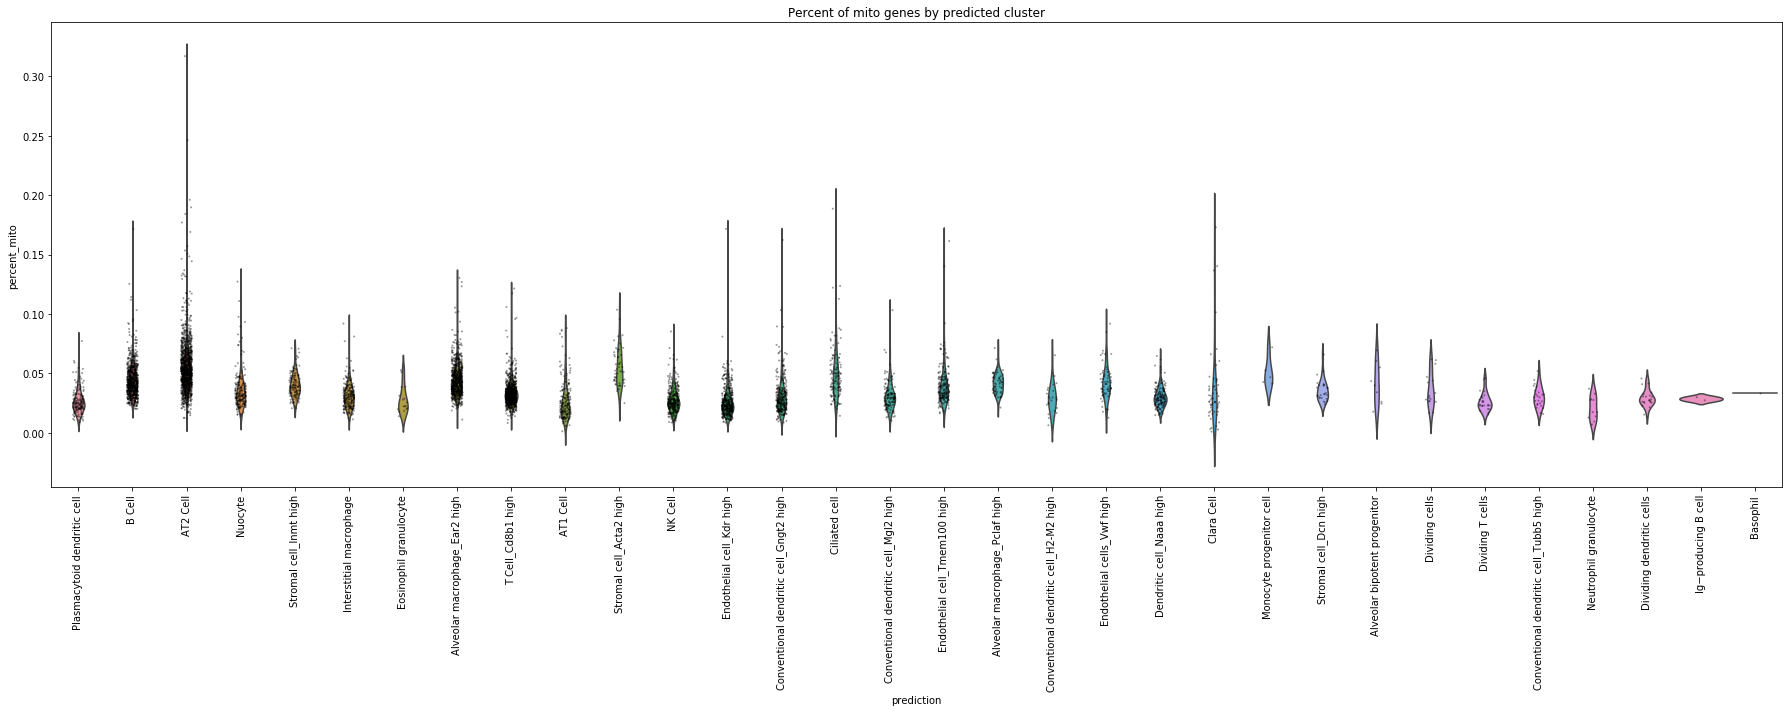

In [68]:
violin(df, 'prediction', 'percent_mito', 'Percent of mito genes by predicted cluster')

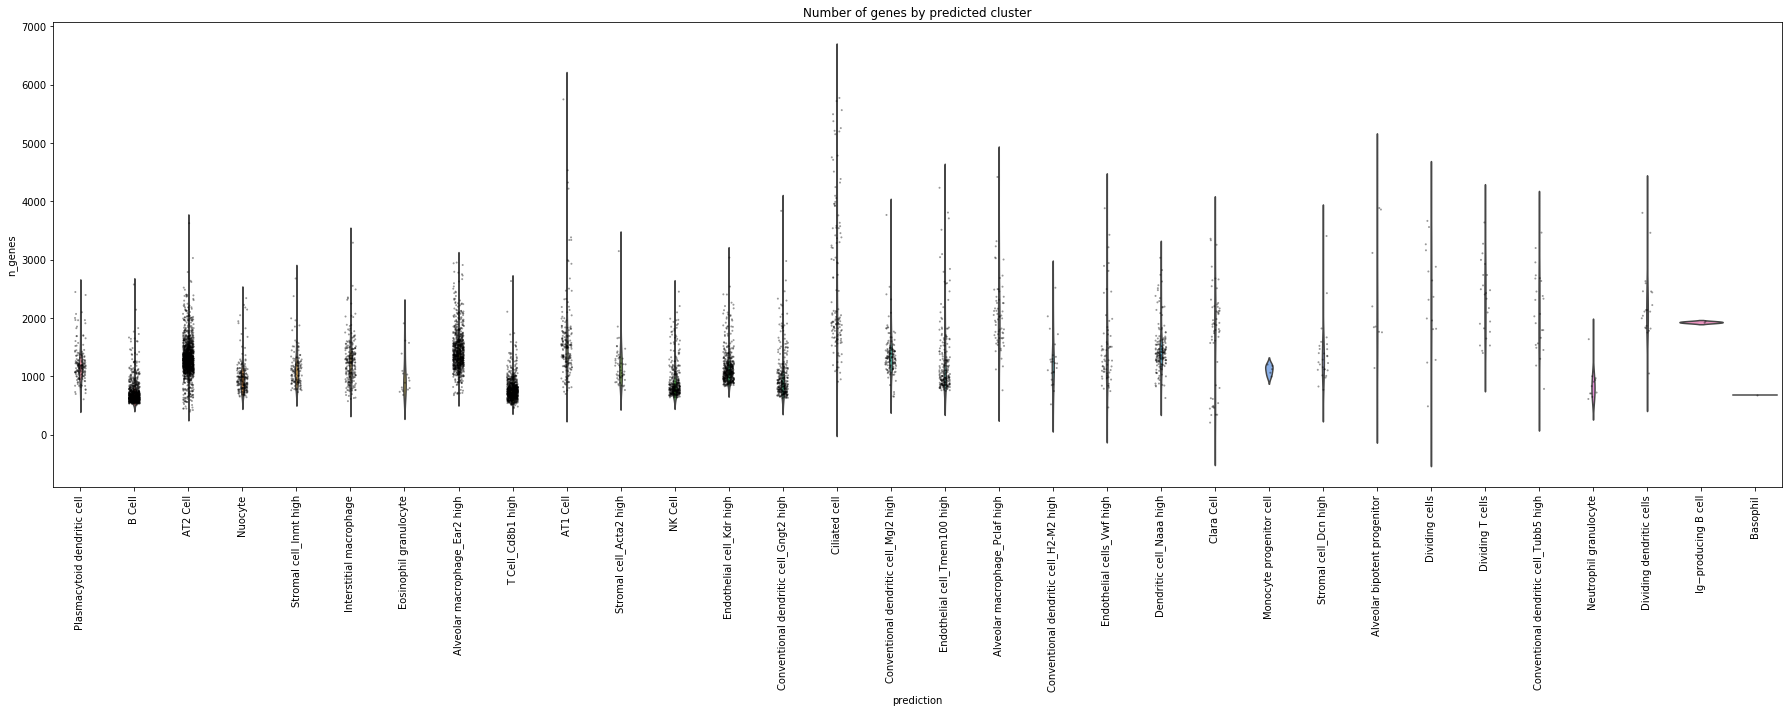

In [69]:
violin(df, 'prediction', 'n_genes', 'Number of genes by predicted cluster')

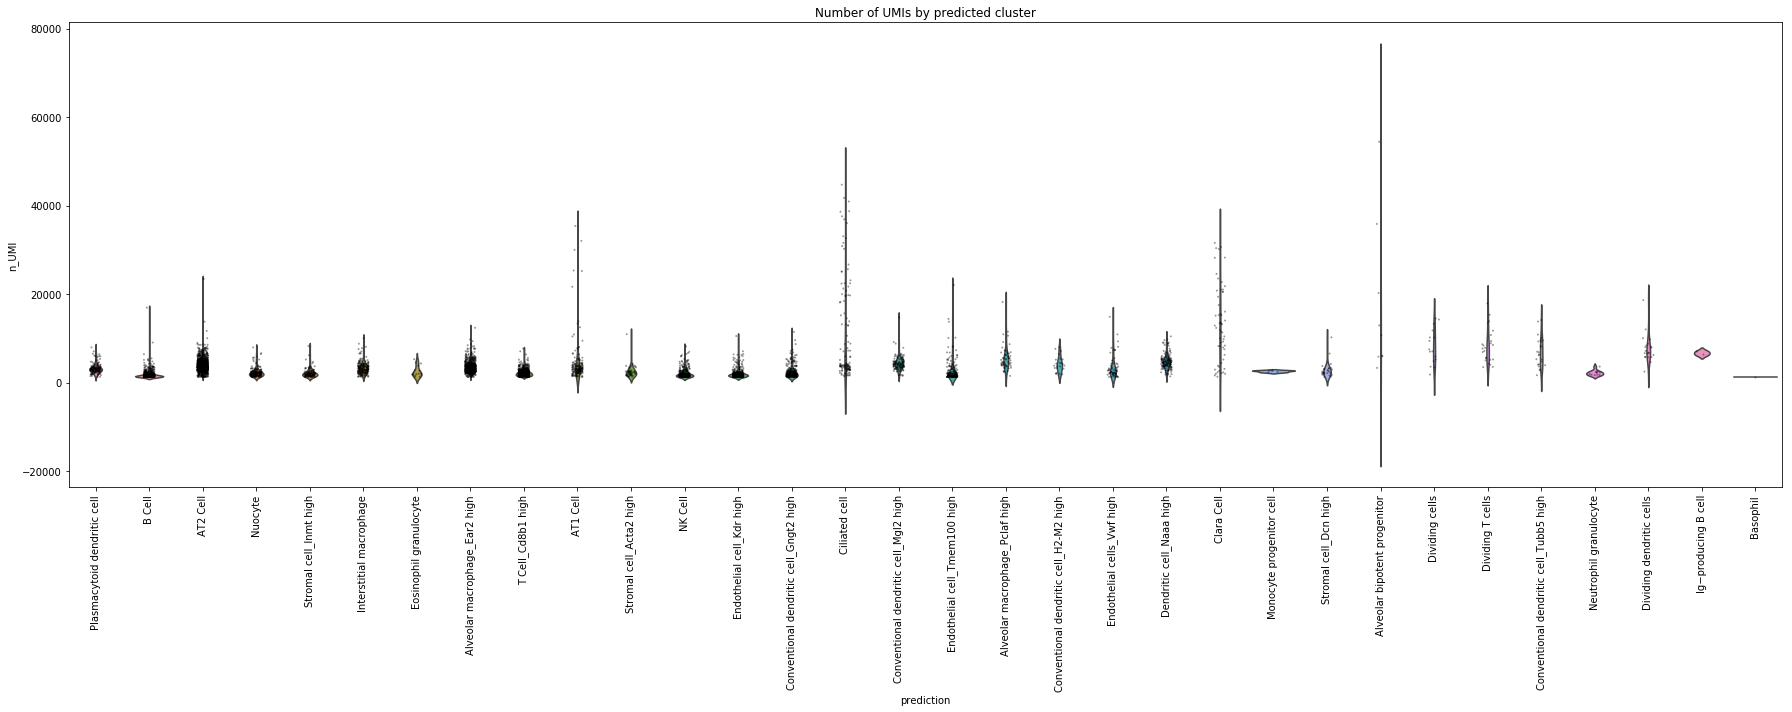

In [70]:
violin(df, 'prediction', 'n_UMI', 'Number of UMIs by predicted cluster')

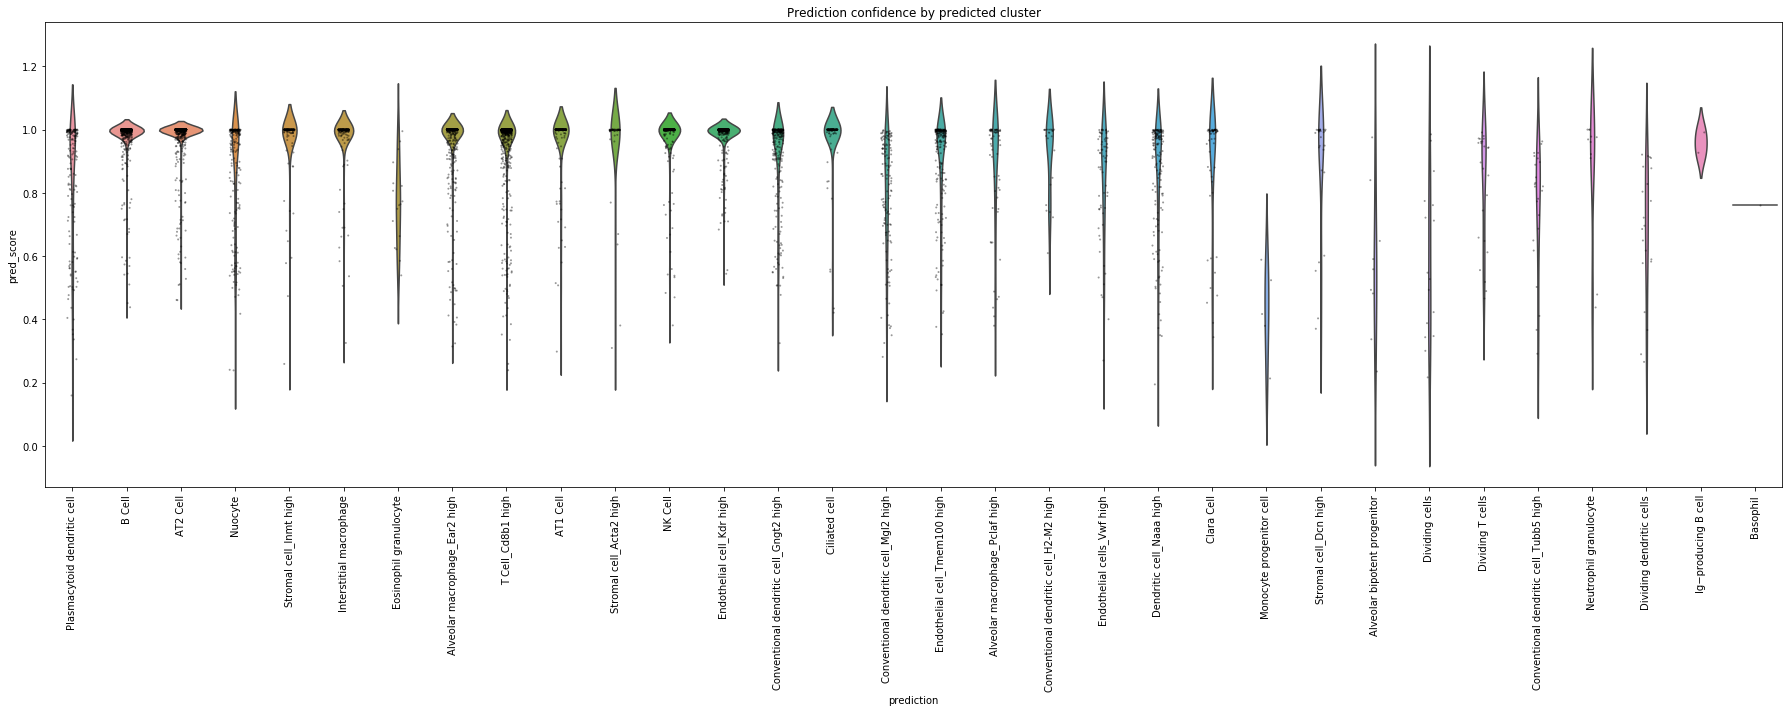

In [71]:
violin(df, 'prediction', 'pred_score', 'Prediction confidence by predicted cluster')

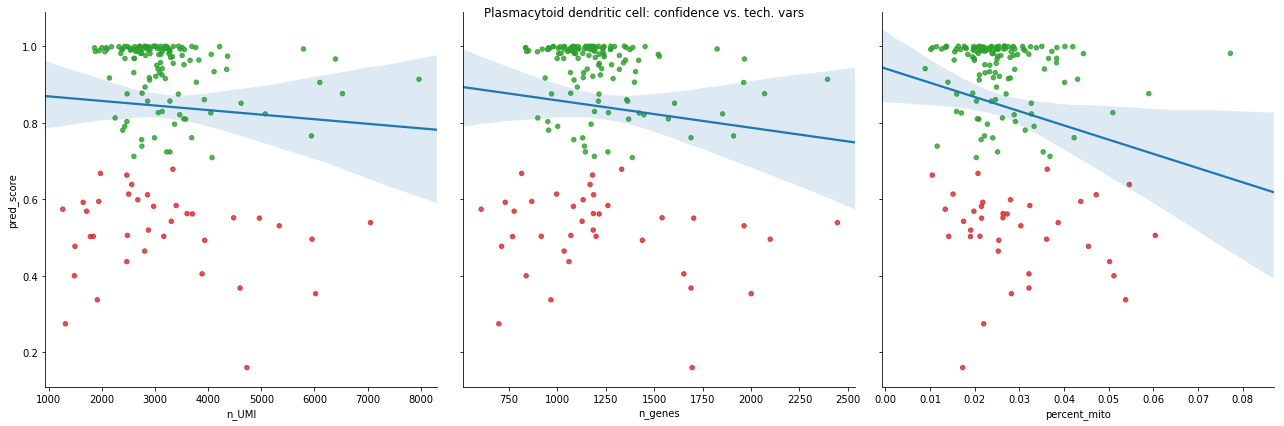

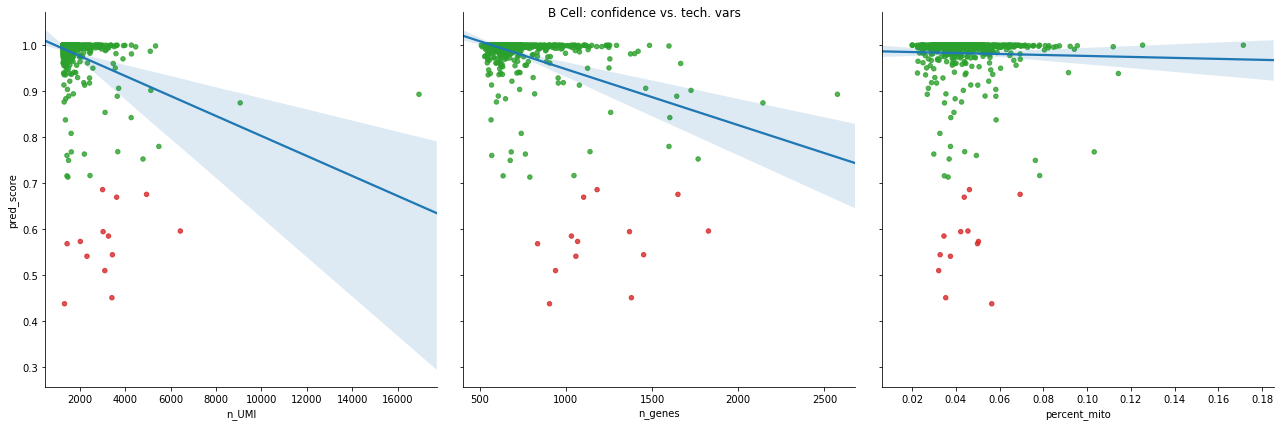

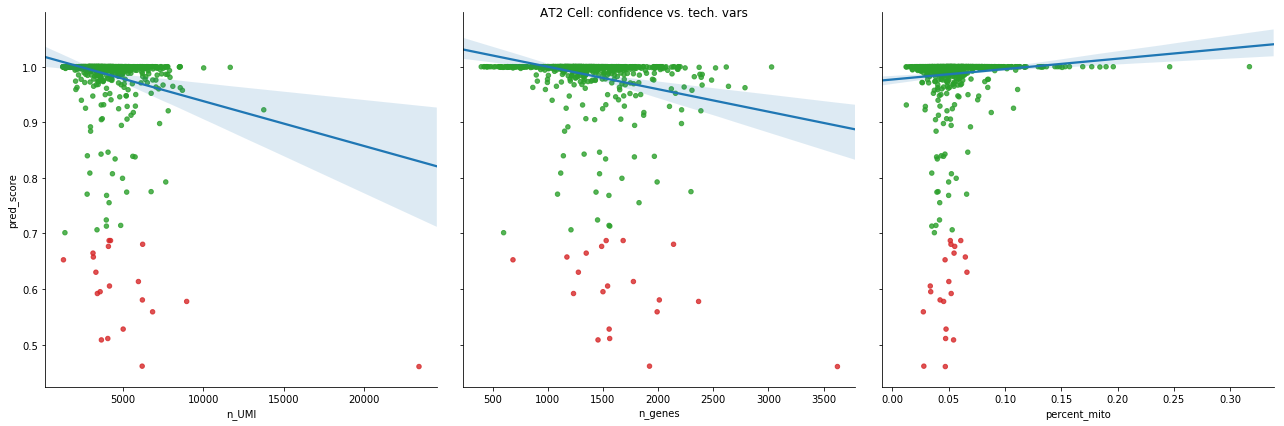

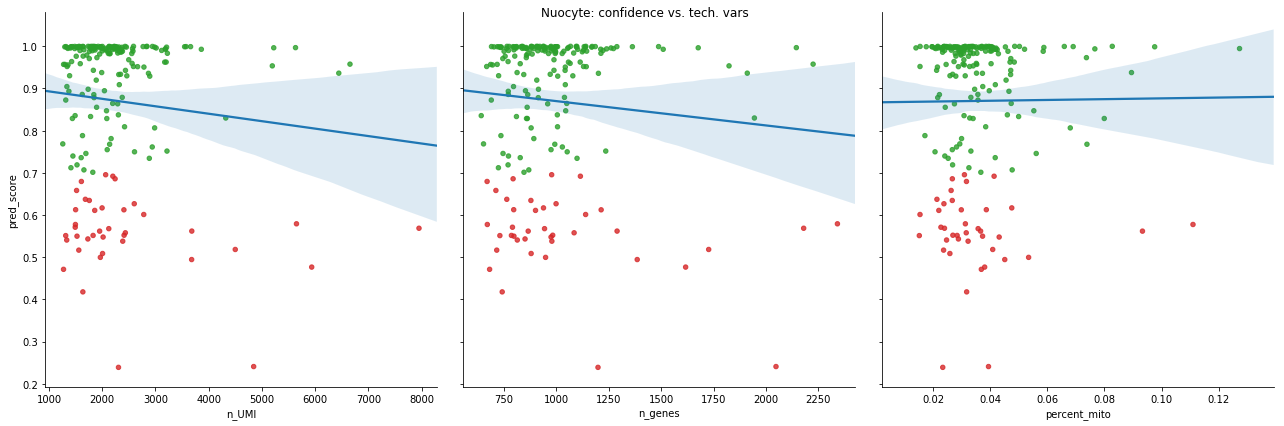

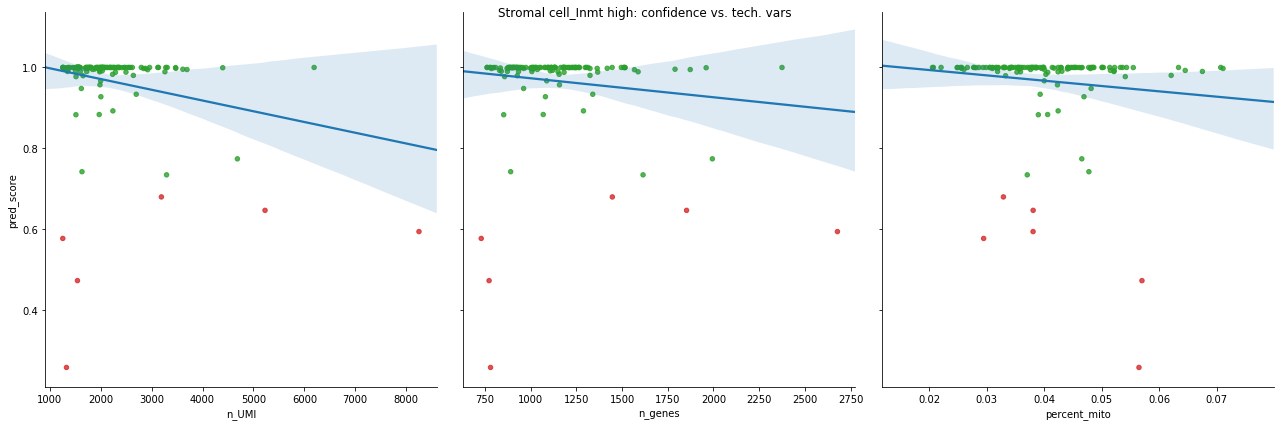

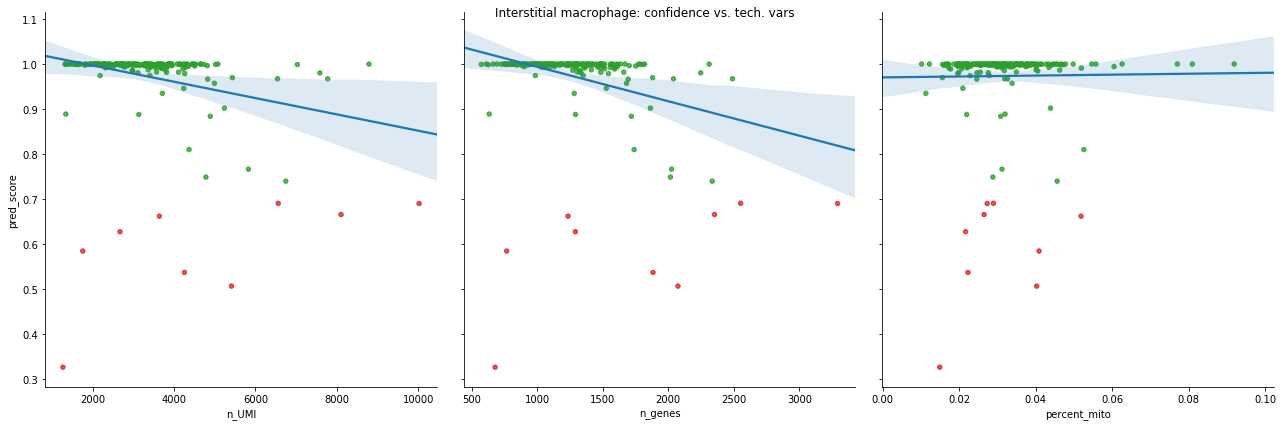

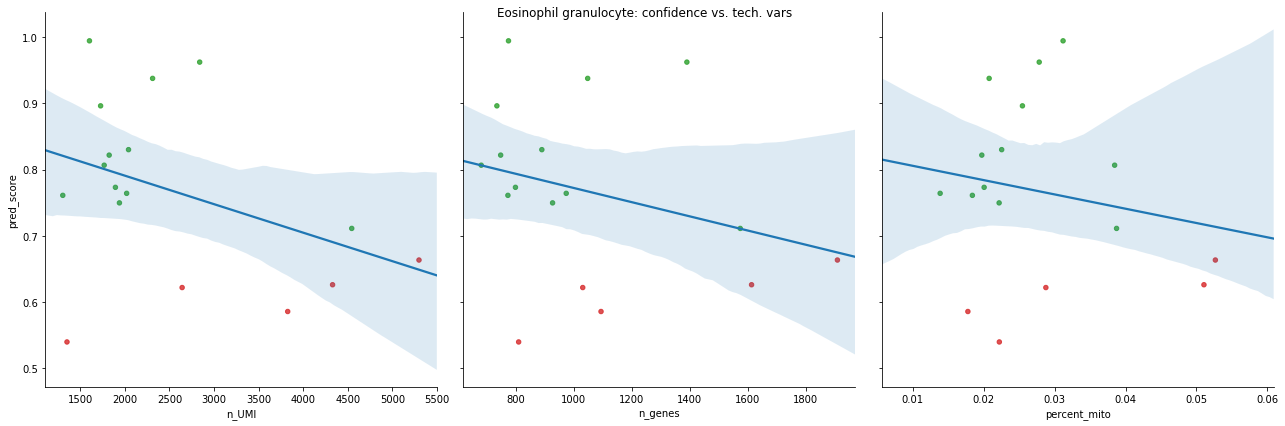

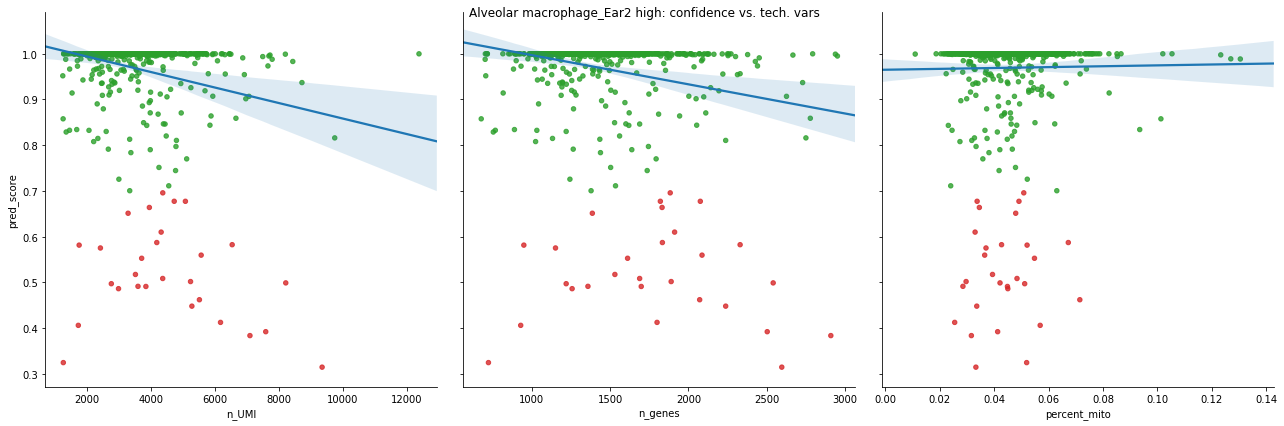

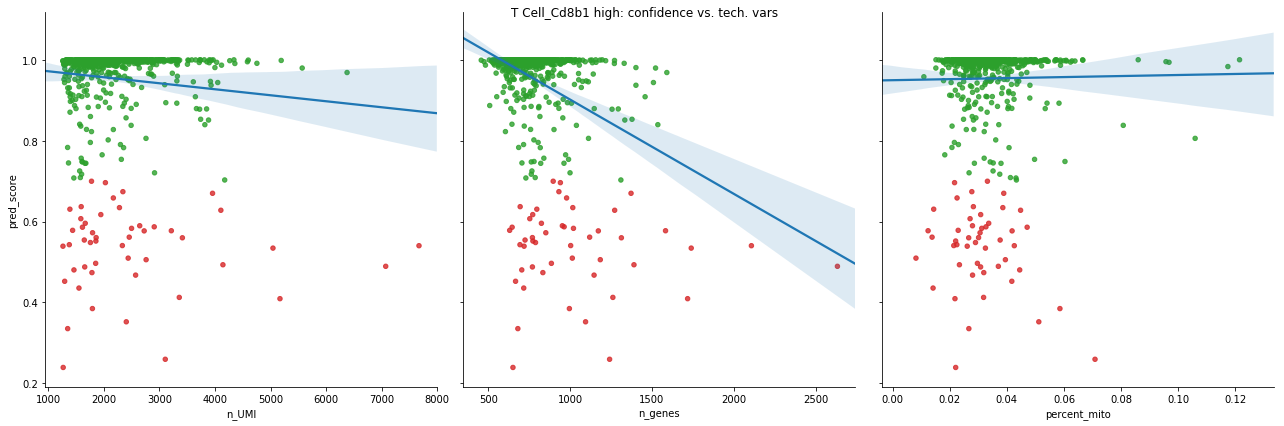

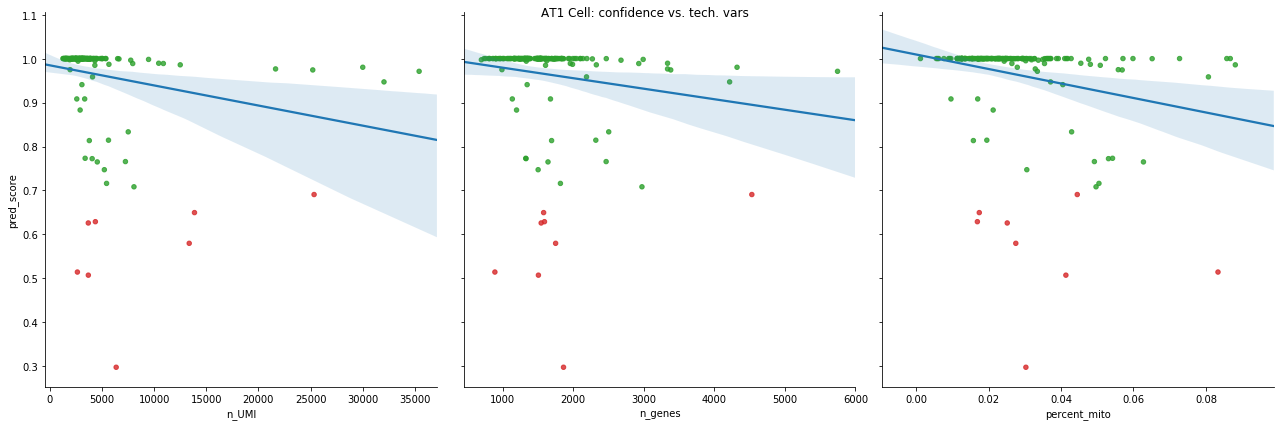

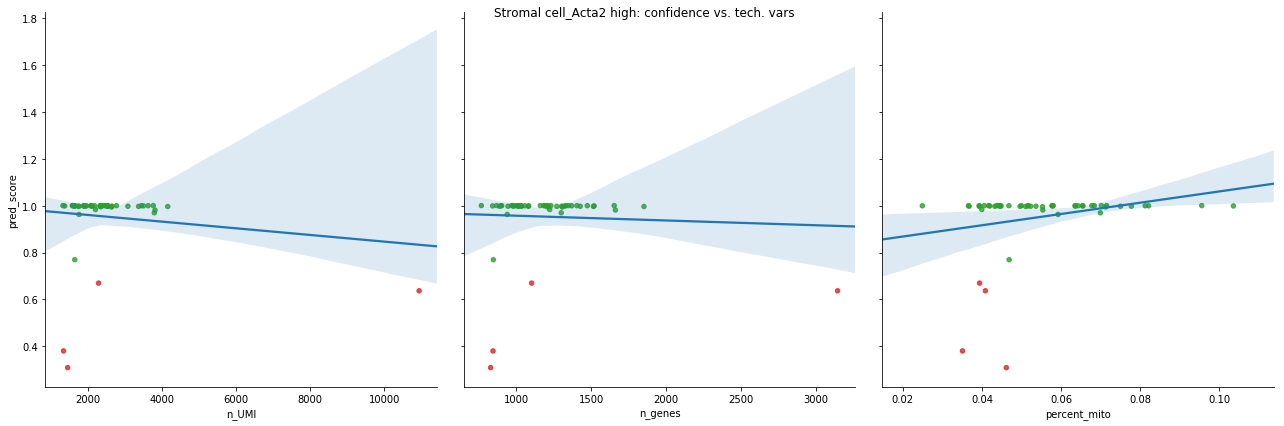

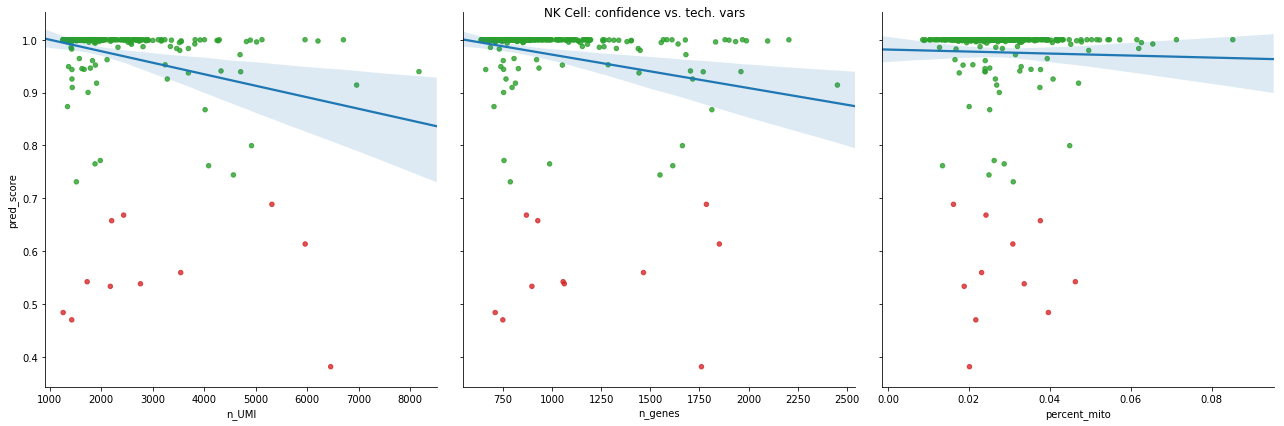

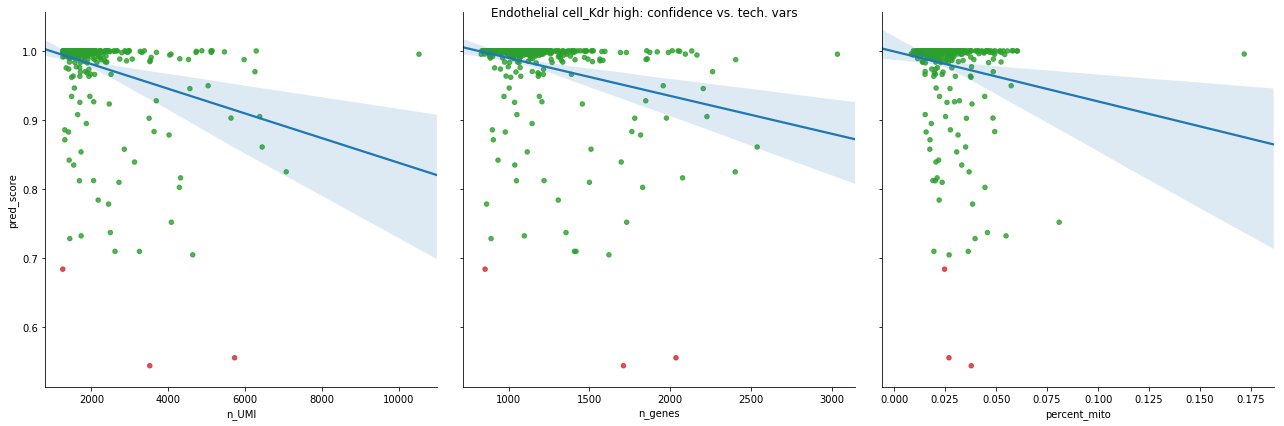

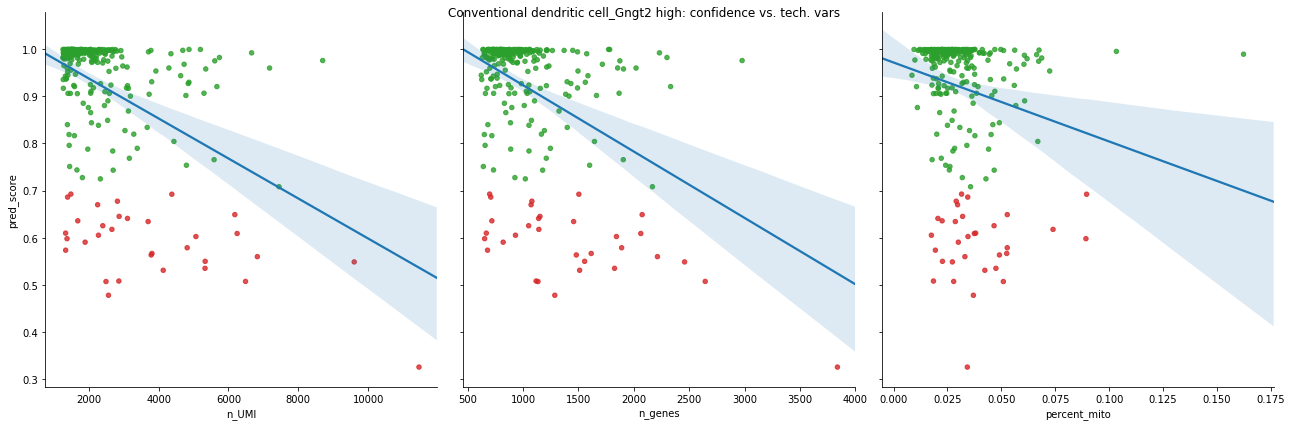

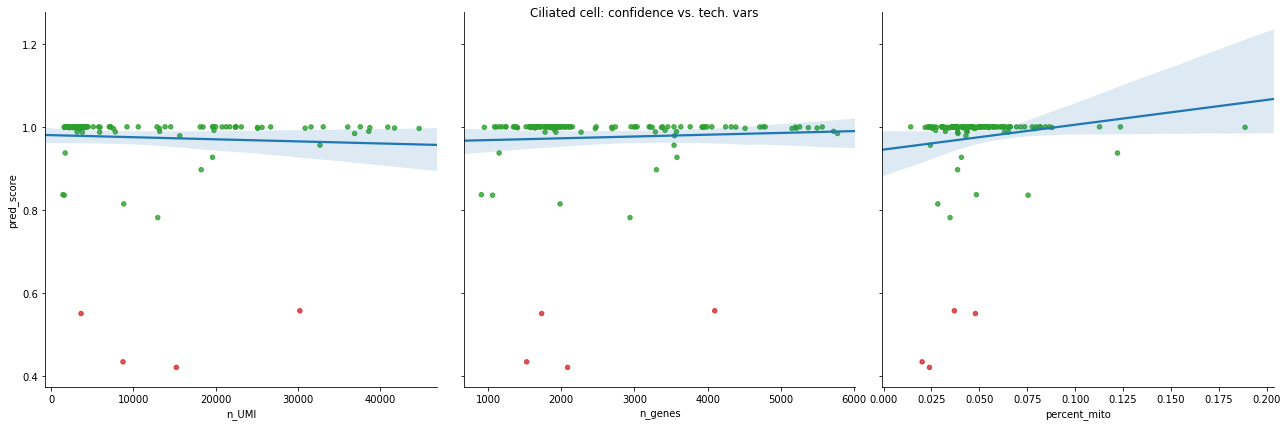

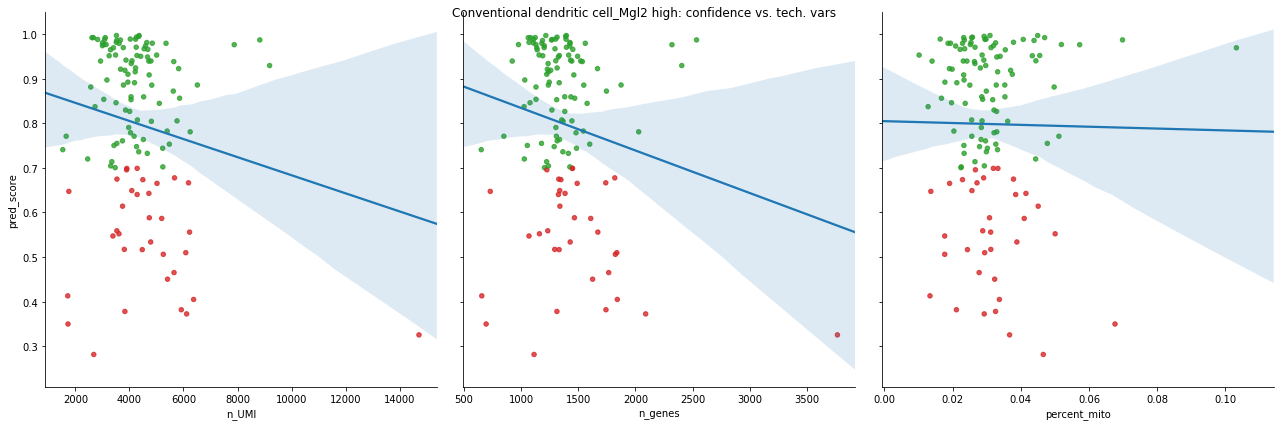

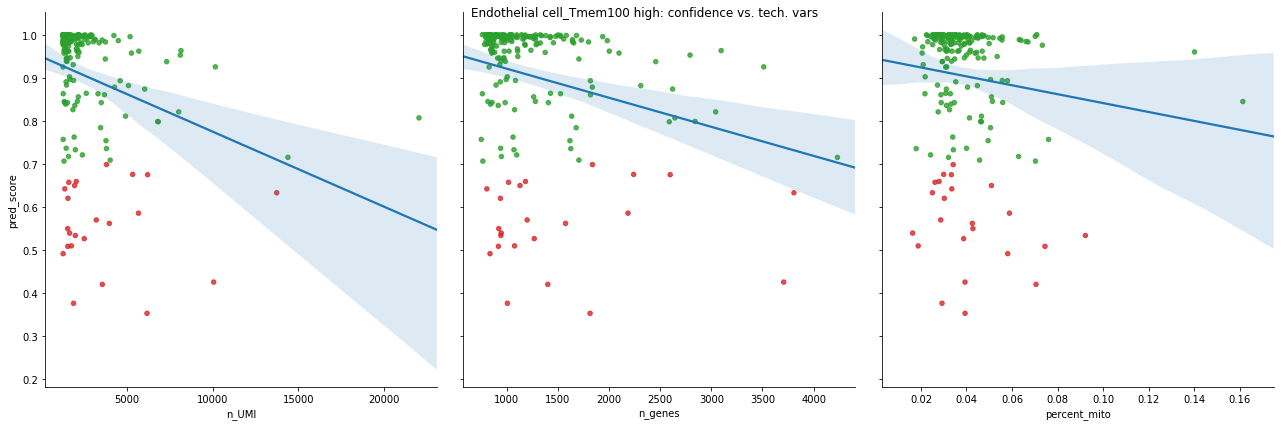

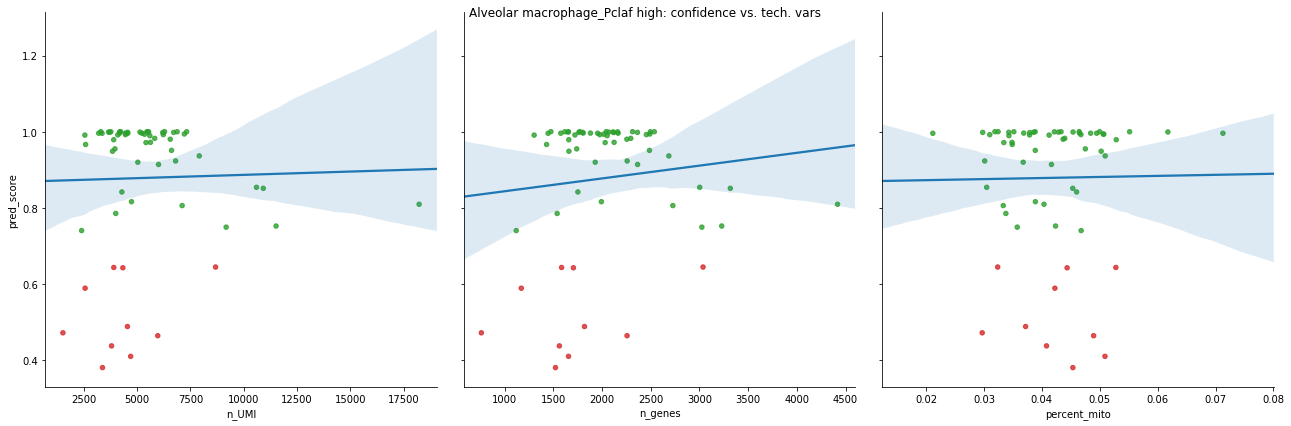

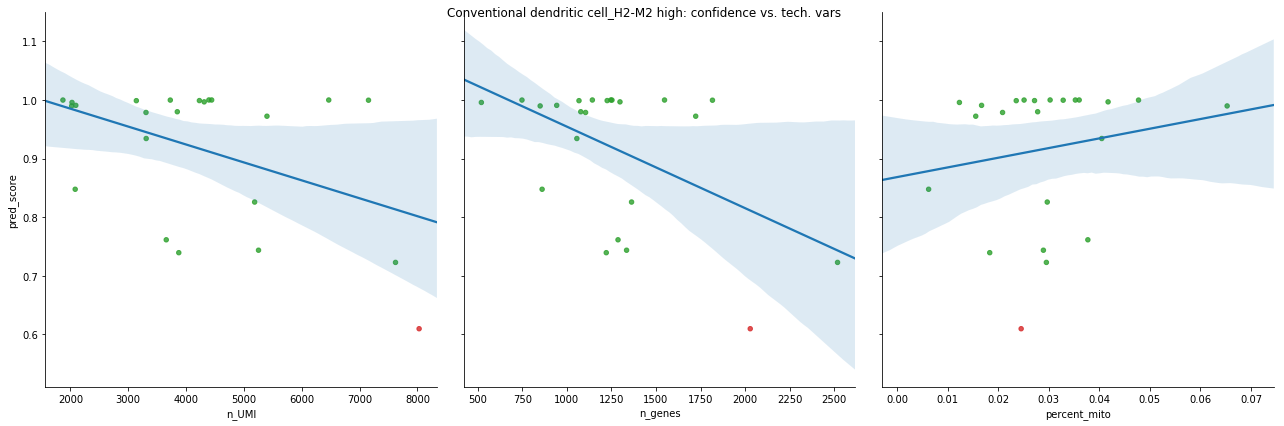

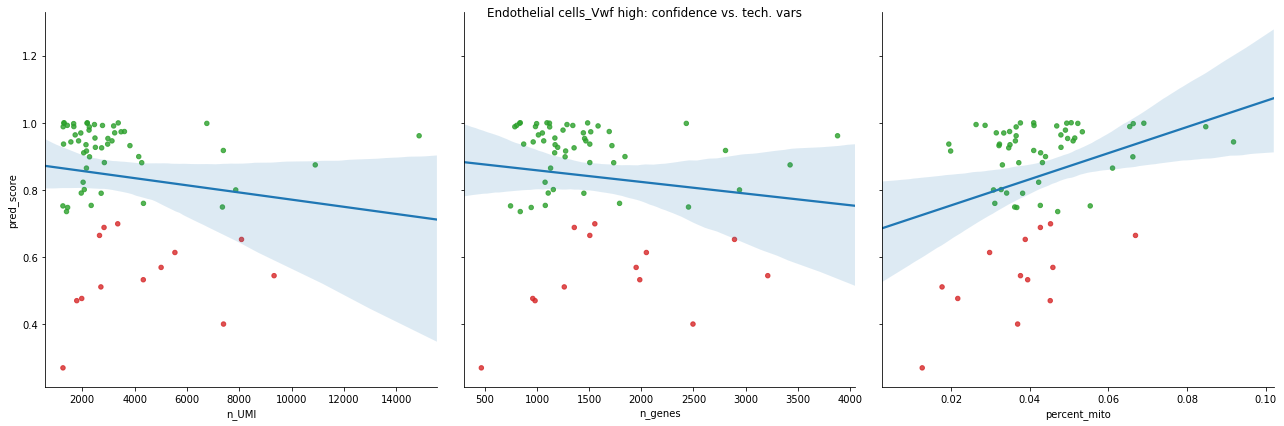

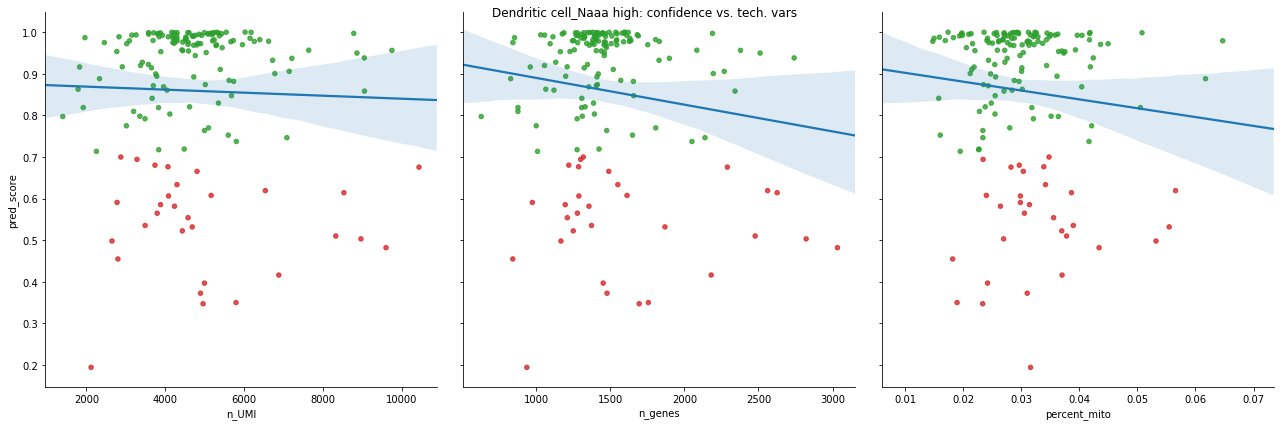

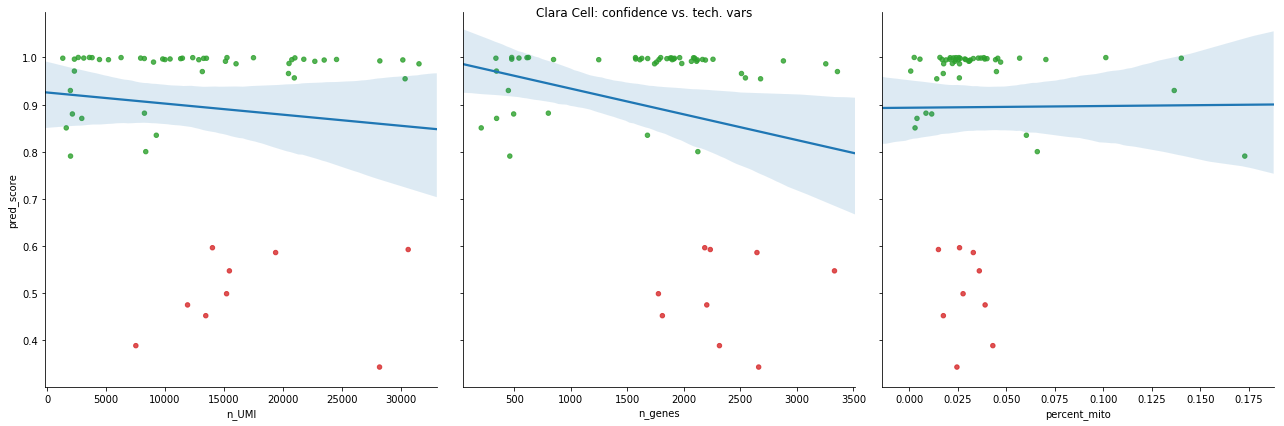

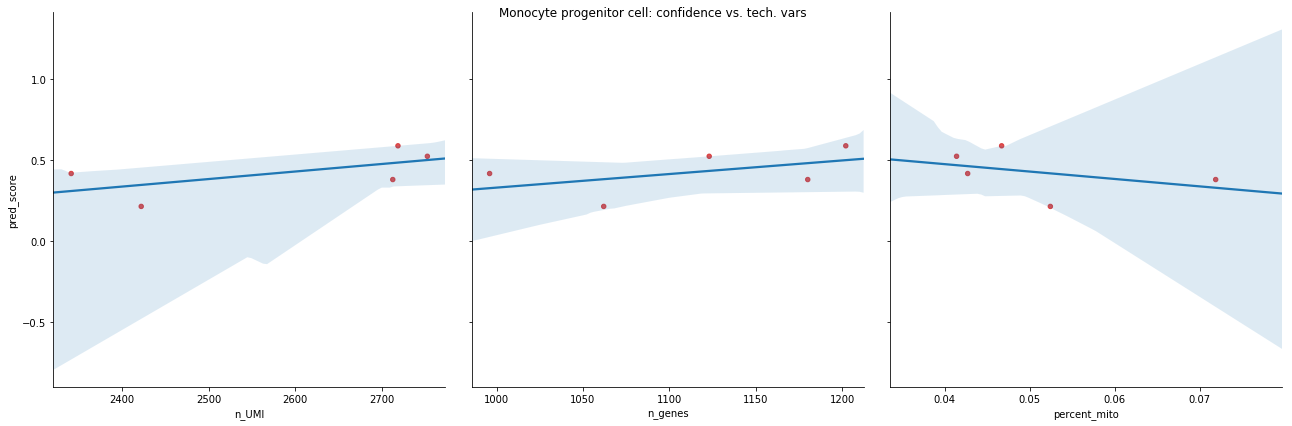

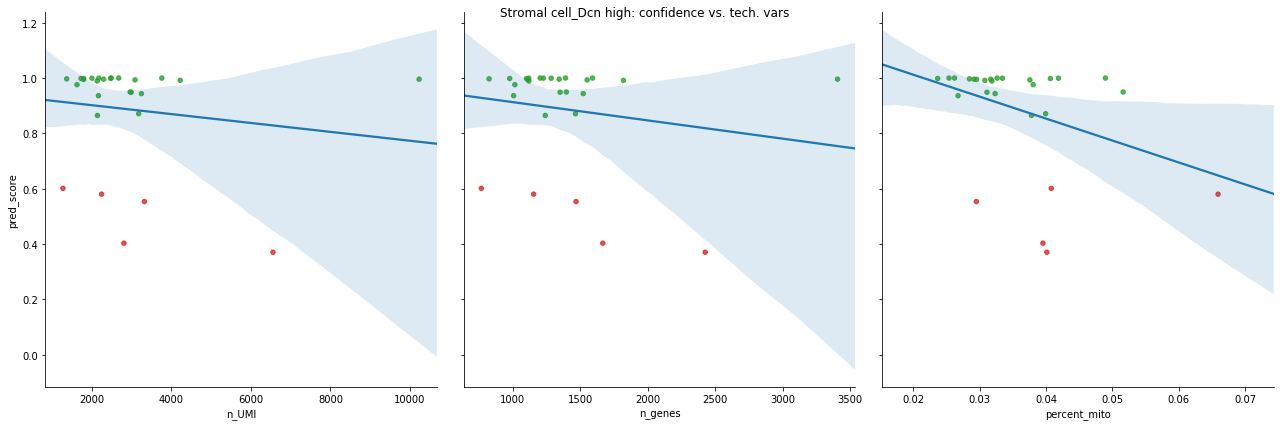

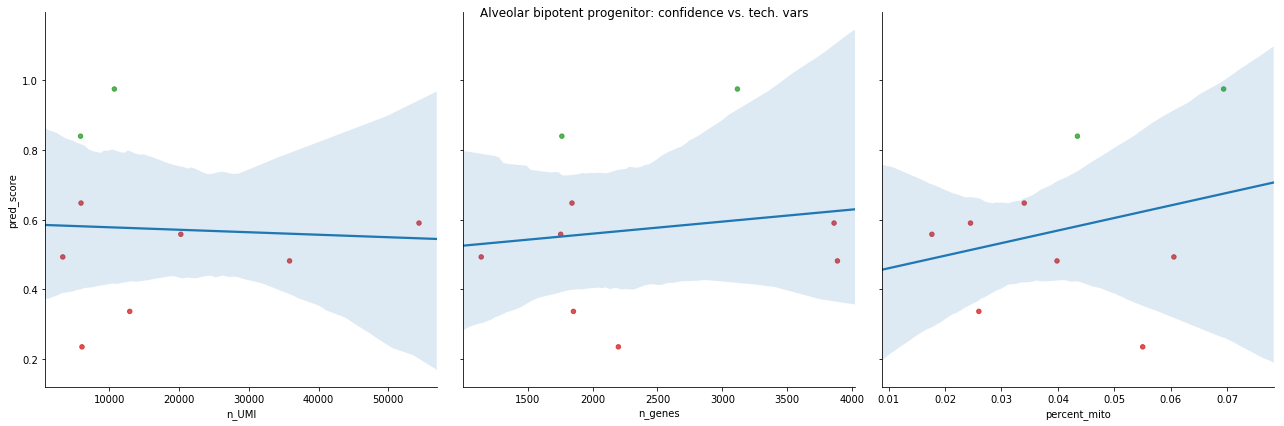

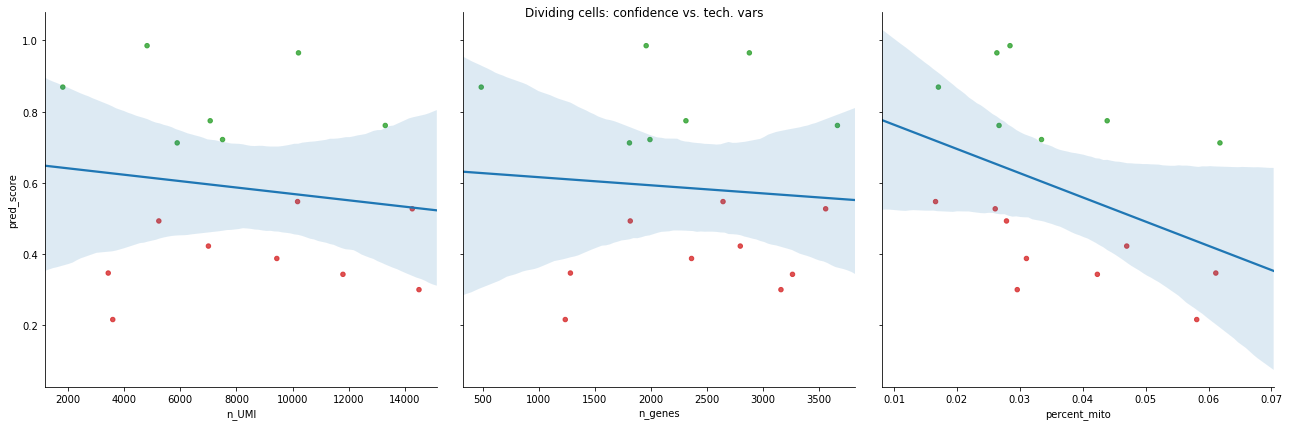

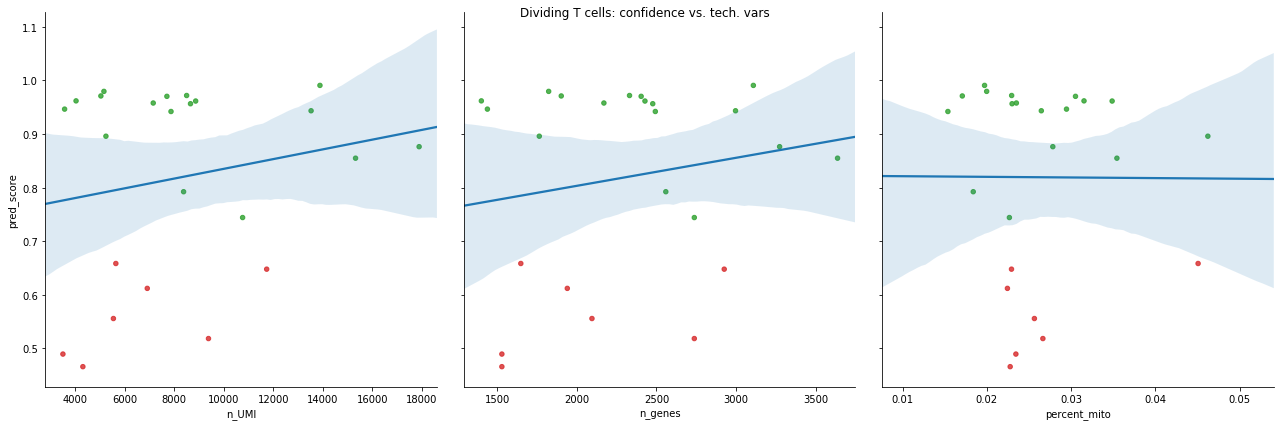

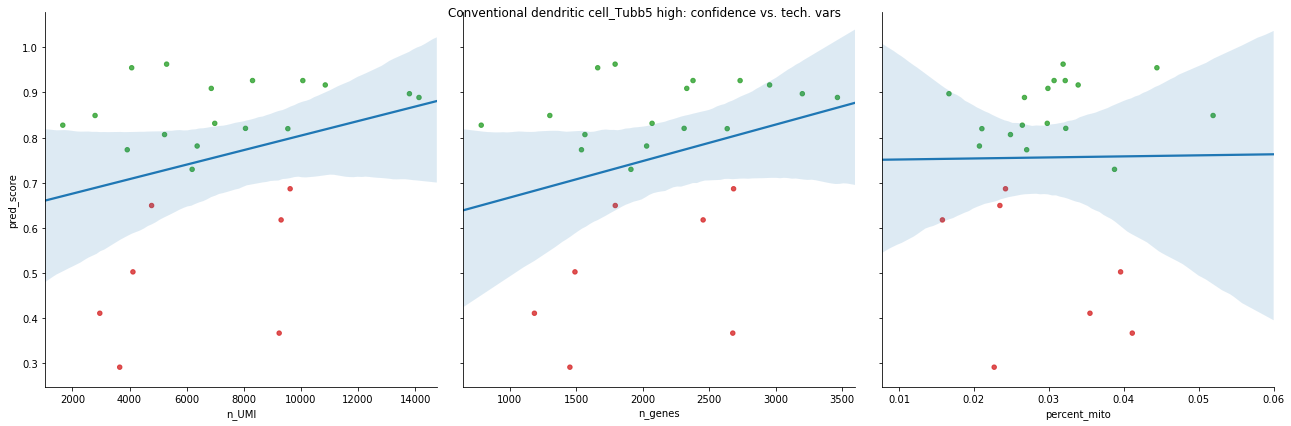

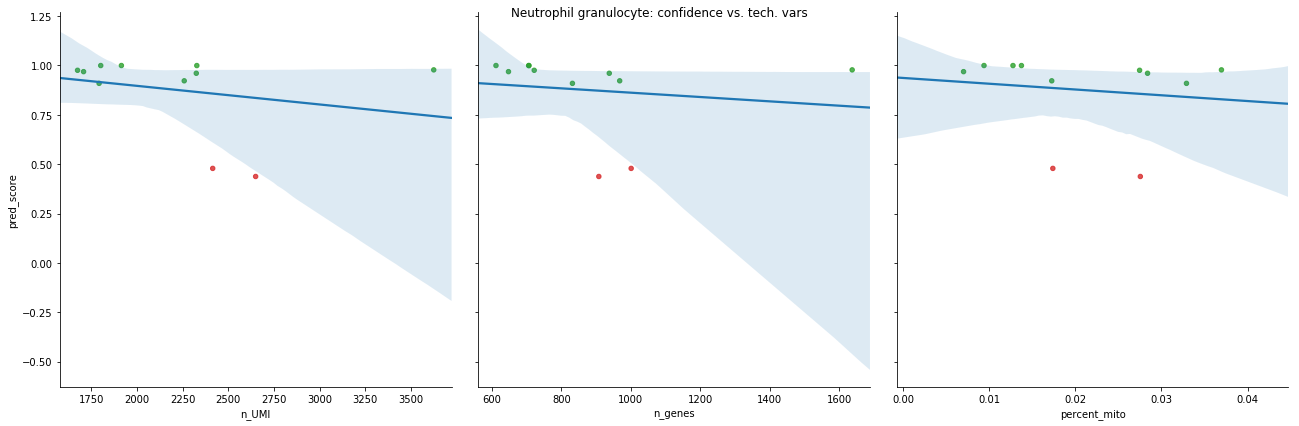

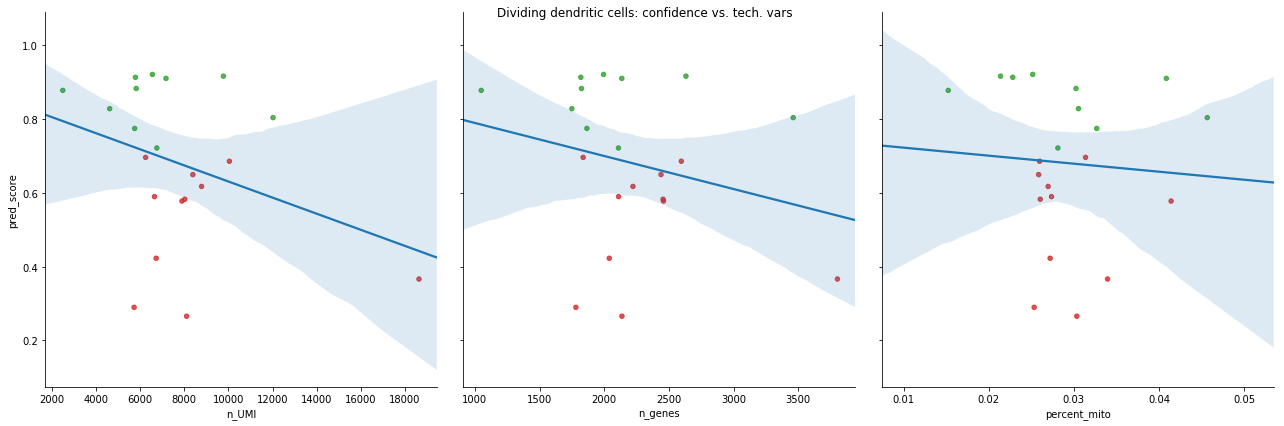

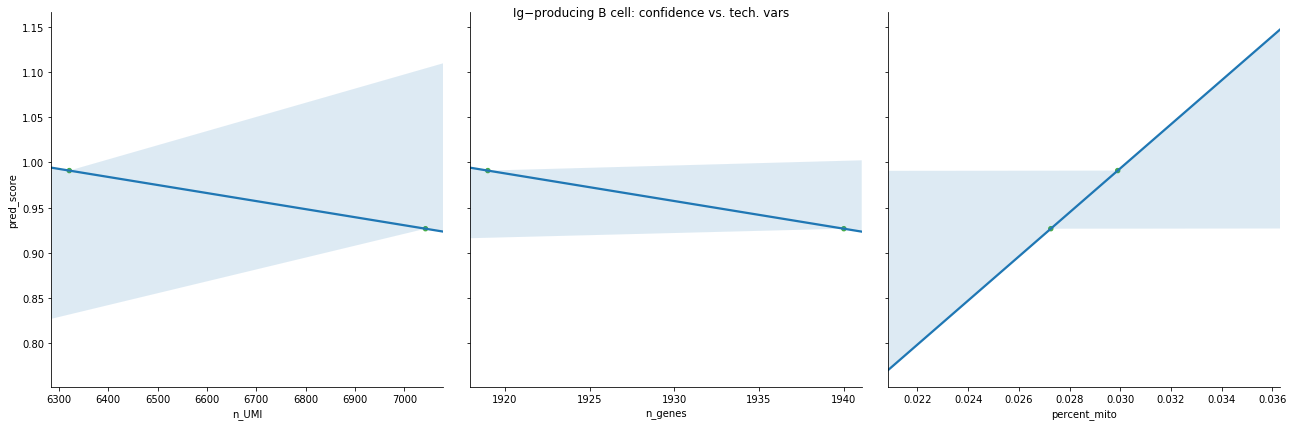

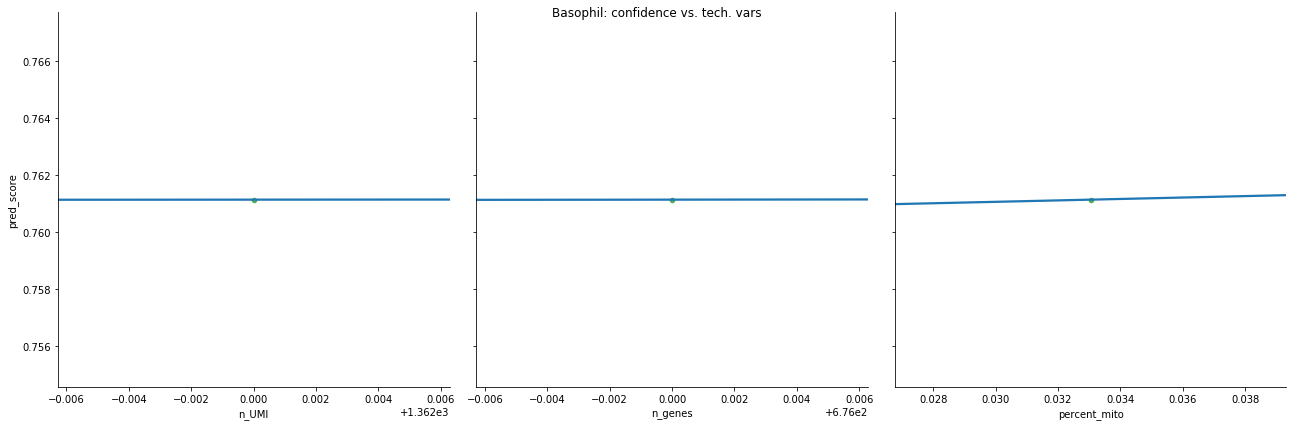

In [113]:
for x in df.prediction.unique():
    dfx = df.loc[df.prediction == x,:]
    seaborn.pairplot(dfx, 
                     x_vars=['n_UMI', 'n_genes', 'percent_mito'], 
                     y_vars=['pred_score'], 
                     plot_kws={
                         'scatter_kws':{
                             's': 20, 
                             'c': 'C' + ((dfx.pred_score < 0.7).astype(int) + 2).astype(str), 
                             'color': None,
                         }
                     },
                     kind='reg',
                     size=6,
                    )
    plt.suptitle('{}: confidence vs. tech. vars'.format(x))
    plt.show()

In [57]:
column = sc01p.columns[0]

Statistics of predictions for AT2 Cell:
count    1337.000000
mean        0.987233
std         0.057009
min         0.460727
25%         0.999008
50%         0.999903
75%         0.999983
max         1.000000
Name: AT2 Cell, dtype: float64


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


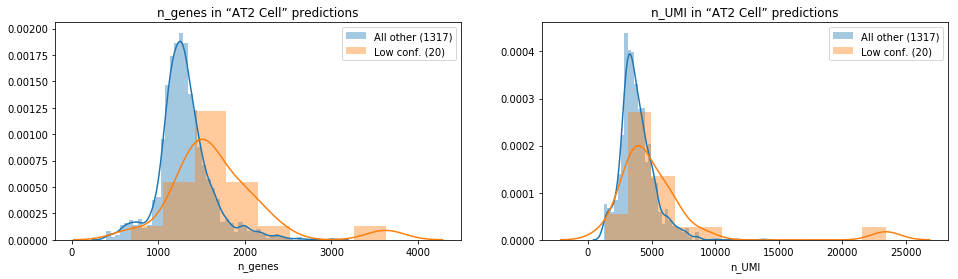

Statistics of predictions for B Cell:
count    823.000000
mean       0.982333
std        0.062528
min        0.438238
25%        0.994500
50%        0.998565
75%        0.999552
max        0.999988
Name: B Cell, dtype: float64


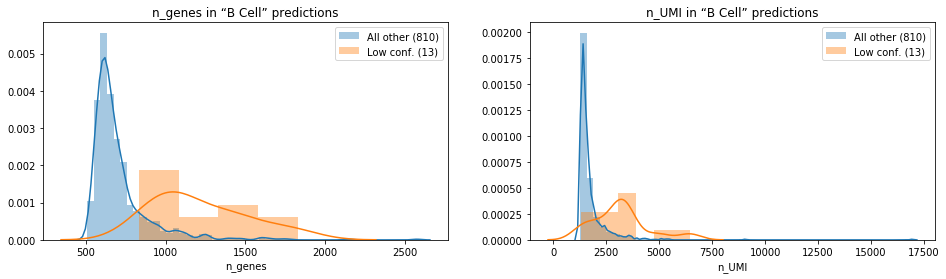

Statistics of predictions for Alveolar macrophage_Ear2 high:
count    776.000000
mean       0.969391
std        0.098317
min        0.314293
25%        0.998542
50%        0.999986
75%        0.999998
max        1.000000
Name: Alveolar macrophage_Ear2 high, dtype: float64


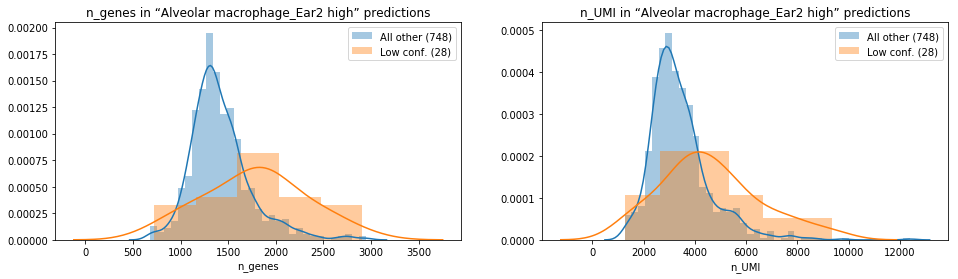

Statistics of predictions for T Cell_Cd8b1 high:
count    825.000000
mean       0.953729
std        0.118064
min        0.239199
25%        0.984435
50%        0.997524
75%        0.999415
max        0.999989
Name: T Cell_Cd8b1 high, dtype: float64


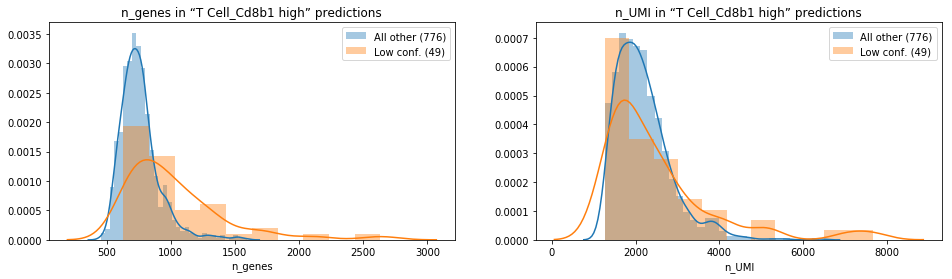

Statistics of predictions for Plasmacytoid dendritic cell:
count    165.000000
mean       0.842613
std        0.198425
min        0.159398
25%        0.738553
50%        0.950187
75%        0.992416
max        0.999978
Name: Plasmacytoid dendritic cell, dtype: float64


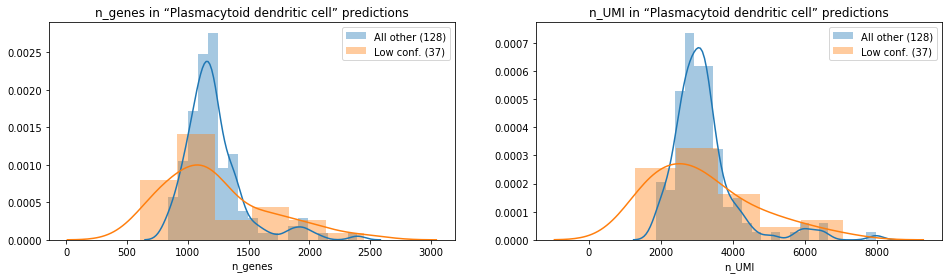

Statistics of predictions for NK Cell:
count    338.000000
mean       0.976117
std        0.086301
min        0.380922
25%        0.999029
50%        0.999956
75%        0.999994
max        1.000000
Name: NK Cell, dtype: float64


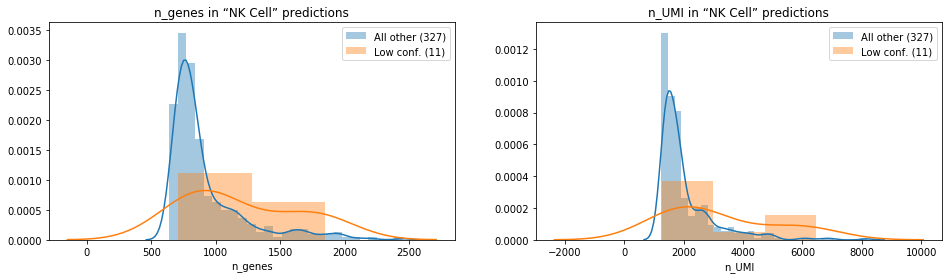

Statistics of predictions for Eosinophil granulocyte:
count    17.000000
mean      0.767230
std       0.133530
min       0.539027
25%       0.663039
50%       0.763993
75%       0.830092
max       0.994800
Name: Eosinophil granulocyte, dtype: float64


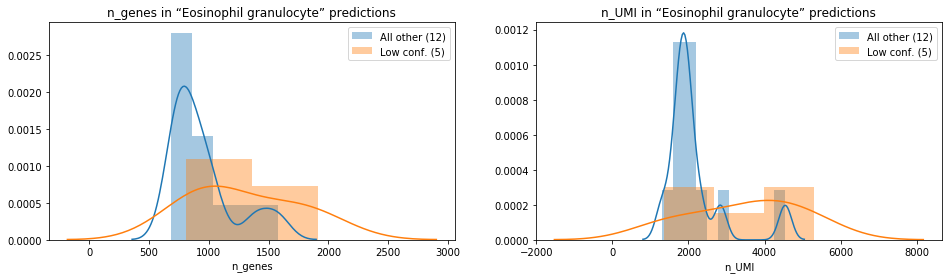

Statistics of predictions for Interstitial macrophage:
count    221.000000
mean       0.973388
std        0.089914
min        0.325453
25%        0.995430
50%        0.999201
75%        0.999832
max        1.000000
Name: Interstitial macrophage, dtype: float64


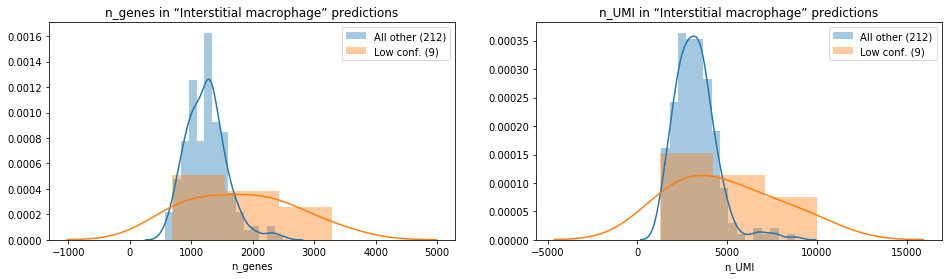

Statistics of predictions for Dendritic cell_Naaa high:
count    156.000000
mean       0.858665
std        0.179171
min        0.194421
25%        0.787202
50%        0.952791
75%        0.987654
max        0.999536
Name: Dendritic cell_Naaa high, dtype: float64


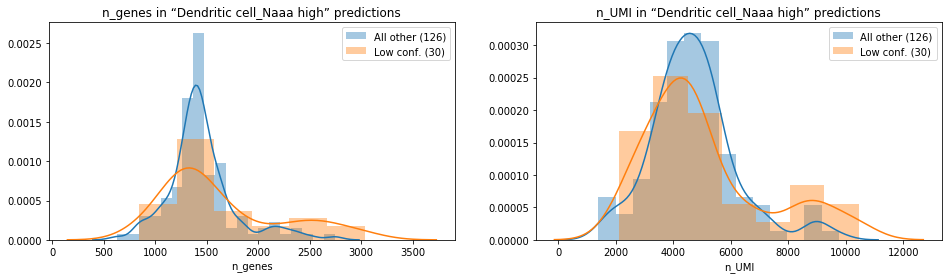

Statistics of predictions for Stromal cell_Dcn high:
count    27.000000
mean      0.887013
std       0.195237
min       0.370311
25%       0.903491
50%       0.991580
75%       0.998273
max       0.999887
Name: Stromal cell_Dcn high, dtype: float64


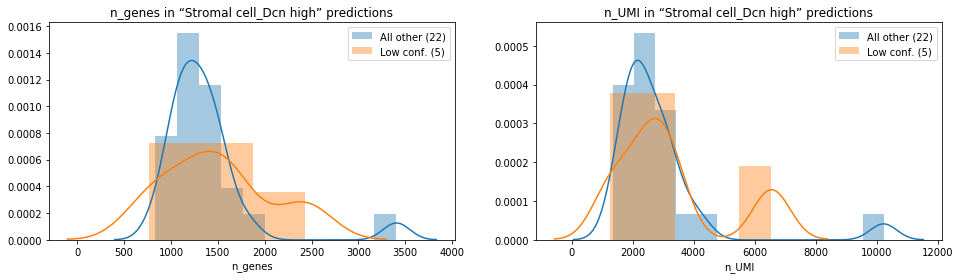

Statistics of predictions for Stromal cell_Inmt high:
count    132.000000
mean       0.966930
std        0.106849
min        0.259114
25%        0.994688
50%        0.999892
75%        0.999968
max        0.999998
Name: Stromal cell_Inmt high, dtype: float64


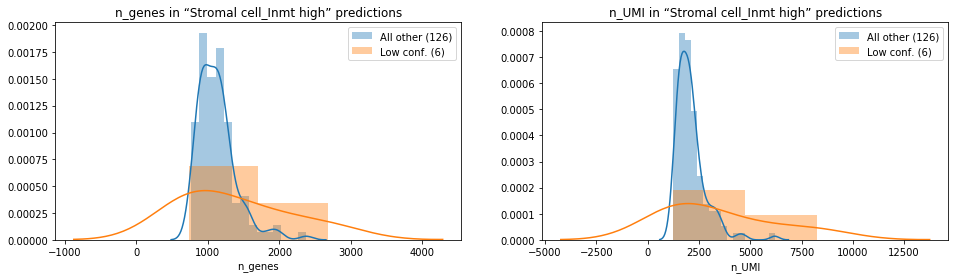

Statistics of predictions for Clara Cell:
count    57.000000
mean      0.894633
std       0.183863
min       0.343589
25%       0.880098
50%       0.992586
75%       0.997625
max       0.999894
Name: Clara Cell, dtype: float64


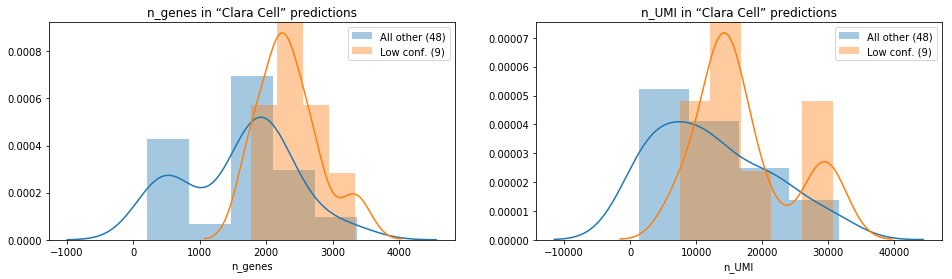

Statistics of predictions for Conventional dendritic cell_Gngt2 high:
count    289.000000
mean       0.920266
std        0.134181
min        0.324738
25%        0.917268
50%        0.988602
75%        0.998048
max        0.999991
Name: Conventional dendritic cell_Gngt2 high, dtype: float64


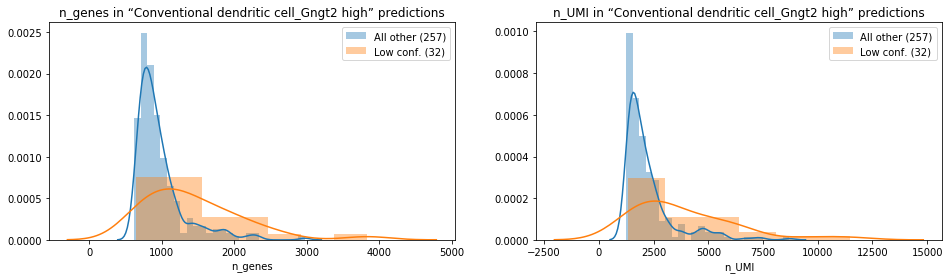

Statistics of predictions for AT1 Cell:
count    185.000000
mean       0.964986
std        0.104231
min        0.298083
25%        0.999580
50%        0.999997
75%        0.999999
max        1.000000
Name: AT1 Cell, dtype: float64


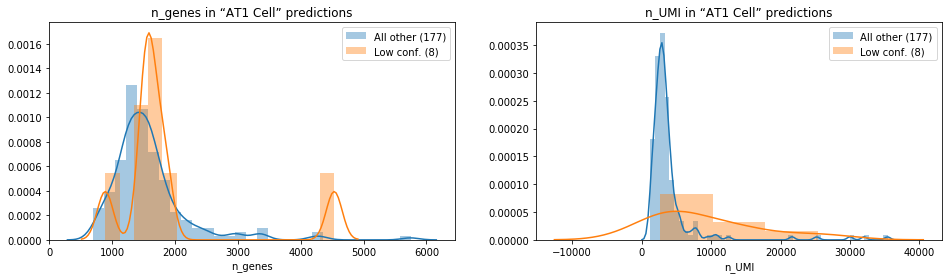

Statistics of predictions for Conventional dendritic cell_Mgl2 high:
count    128.000000
mean       0.798418
std        0.184585
min        0.281337
25%        0.698081
50%        0.853468
75%        0.953212
max        0.997083
Name: Conventional dendritic cell_Mgl2 high, dtype: float64


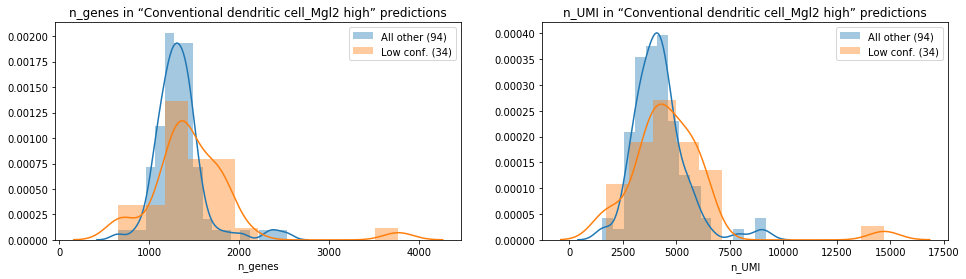

Statistics of predictions for Nuocyte:
count    204.000000
mean       0.870518
std        0.175146
min        0.238717
25%        0.766160
50%        0.965931
75%        0.996873
max        0.999986
Name: Nuocyte, dtype: float64


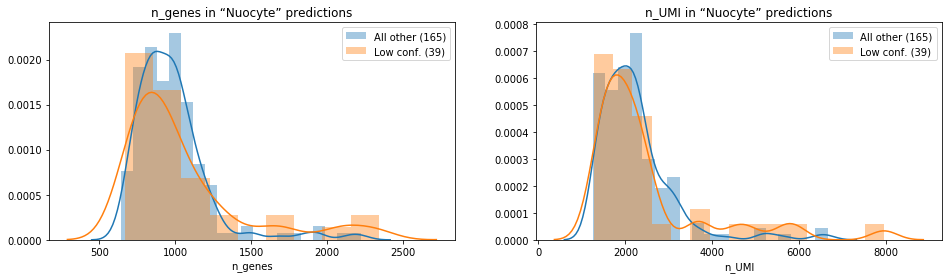

Statistics of predictions for Endothelial cell_Tmem100 high:
count    202.000000
mean       0.903730
std        0.147005
min        0.352951
25%        0.862741
50%        0.979961
75%        0.995708
max        0.999979
Name: Endothelial cell_Tmem100 high, dtype: float64


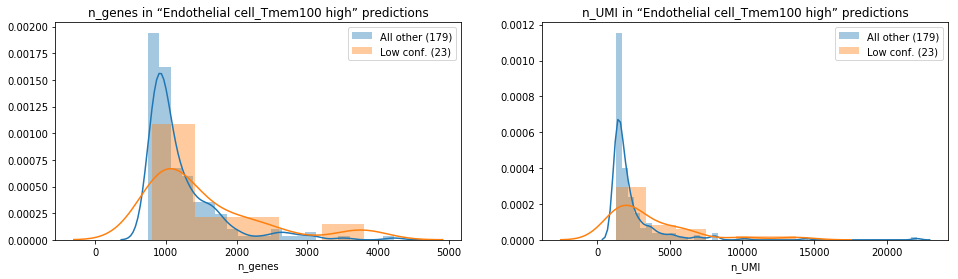

Statistics of predictions for Ciliated cell:
count    128.000000
mean       0.974812
std        0.094370
min        0.421137
25%        0.998224
50%        0.999882
75%        0.999978
max        1.000000
Name: Ciliated cell, dtype: float64


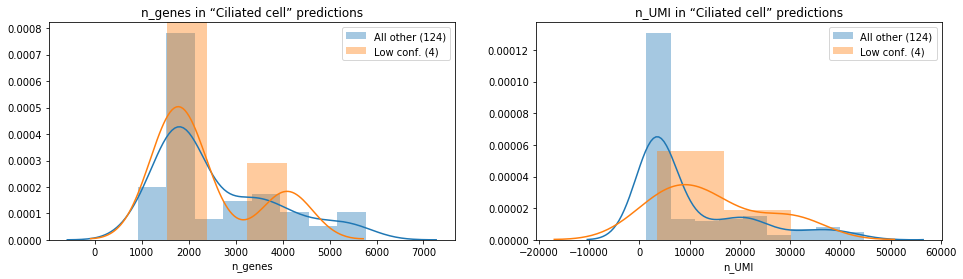

Statistics of predictions for Endothelial cell_Kdr high:
count    439.000000
mean       0.980315
std        0.058450
min        0.544089
25%        0.994409
50%        0.999235
75%        0.999889
max        0.999997
Name: Endothelial cell_Kdr high, dtype: float64


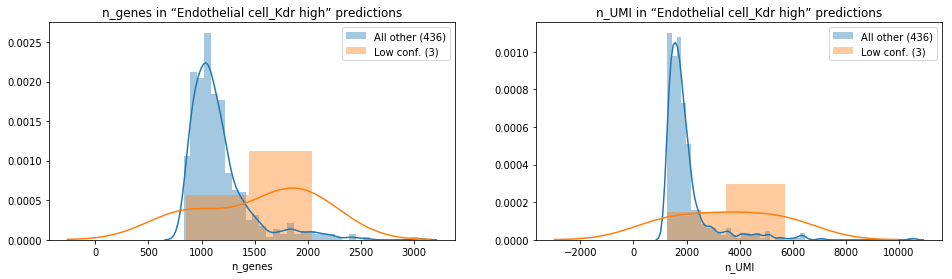

Statistics of predictions for Endothelial cells_Vwf high:
count    65.000000
mean      0.841166
std       0.174989
min       0.269897
25%       0.752171
50%       0.917223
75%       0.972842
max       0.999838
Name: Endothelial cells_Vwf high, dtype: float64


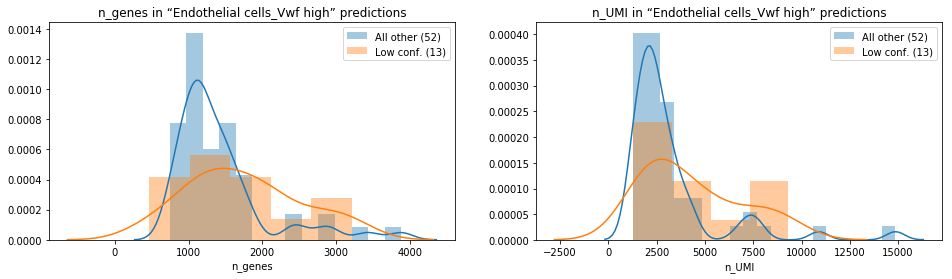

Statistics of predictions for Neutrophil granulocyte:
count    11.000000
mean      0.875512
std       0.208662
min       0.437651
25%       0.915962
50%       0.968832
75%       0.988744
max       0.999883
Name: Neutrophil granulocyte, dtype: float64


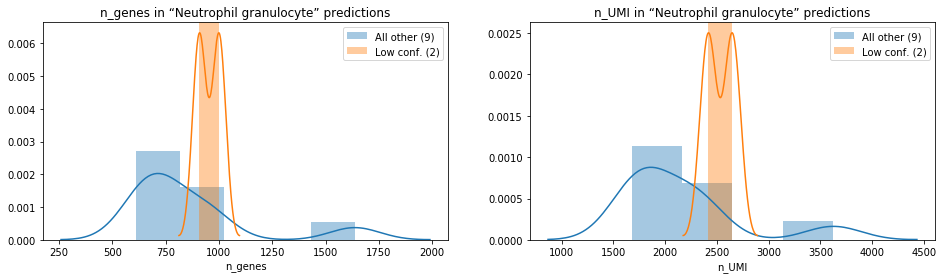

Statistics of predictions for Dividing dendritic cells:
count    21.000000
mean      0.680503
std       0.208658
min       0.265606
25%       0.582673
50%       0.696028
75%       0.877550
max       0.920852
Name: Dividing dendritic cells, dtype: float64


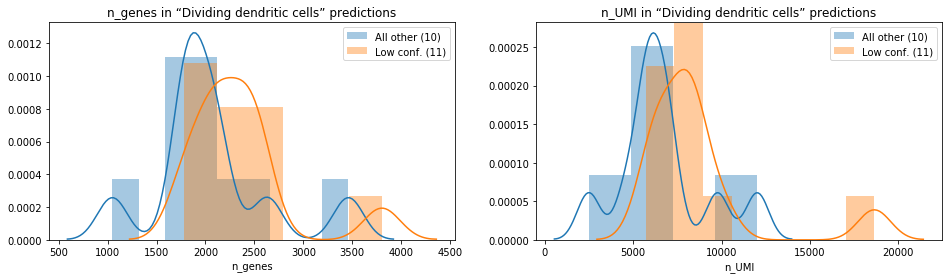

Statistics of predictions for Stromal cell_Acta2 high:
count    51.000000
mean      0.952906
std       0.144544
min       0.309554
25%       0.996641
50%       0.998395
75%       0.999571
max       0.999976
Name: Stromal cell_Acta2 high, dtype: float64


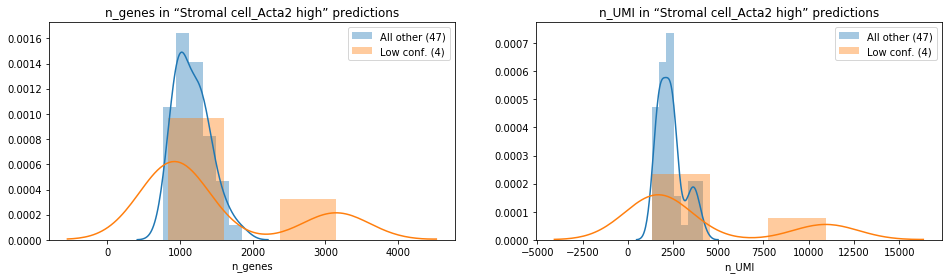

Statistics of predictions for Dividing T cells:
count    24.000000
mean      0.819400
std       0.181631
min       0.465793
25%       0.655753
50%       0.919071
75%       0.961726
max       0.990844
Name: Dividing T cells, dtype: float64


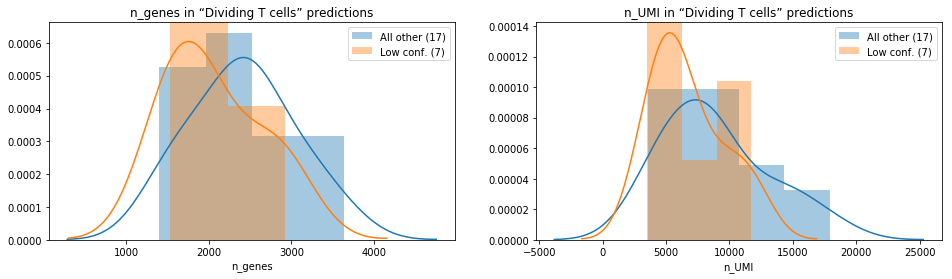

Statistics of predictions for Dividing cells:
count    16.000000
mean      0.585867
std       0.244408
min       0.216661
25%       0.377740
50%       0.537408
75%       0.764383
max       0.984863
Name: Dividing cells, dtype: float64


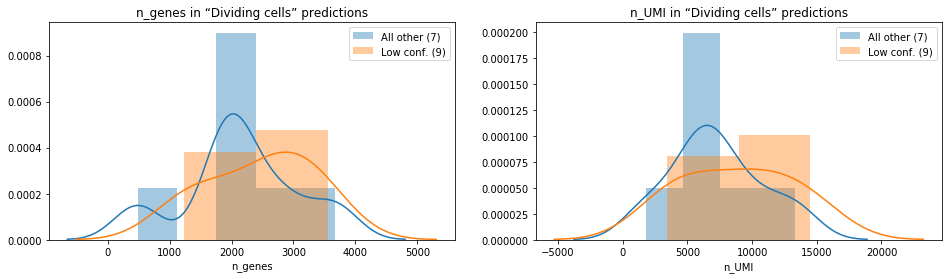

Statistics of predictions for Alveolar macrophage_Pclaf high:
count    62.000000
mean      0.878574
std       0.179583
min       0.379955
25%       0.810851
50%       0.979369
75%       0.997280
max       0.999960
Name: Alveolar macrophage_Pclaf high, dtype: float64


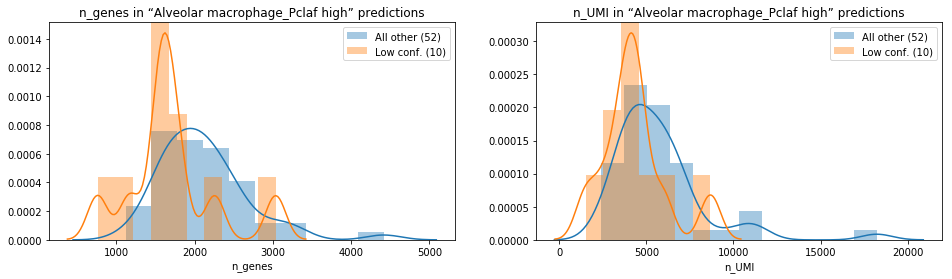

Statistics of predictions for Alveolar bipotent progenitor:
count    9.000000
mean     0.573299
std      0.230144
min      0.235246
25%      0.481898
50%      0.558352
75%      0.647960
max      0.975342
Name: Alveolar bipotent progenitor, dtype: float64


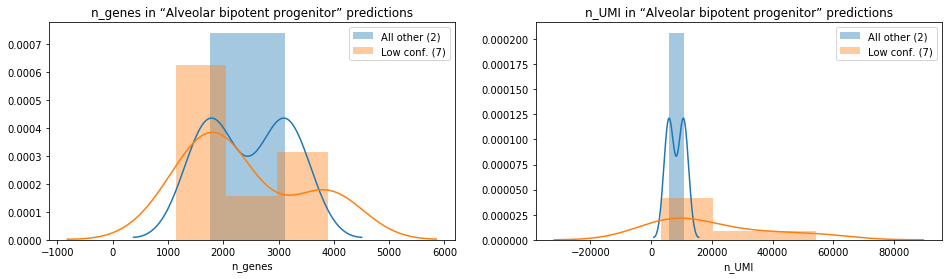

Statistics of predictions for Ig−producing B cell:
count    2.000000
mean     0.958810
std      0.045510
min      0.926629
25%      0.942720
50%      0.958810
75%      0.974900
max      0.990991
Name: Ig−producing B cell, dtype: float64


/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


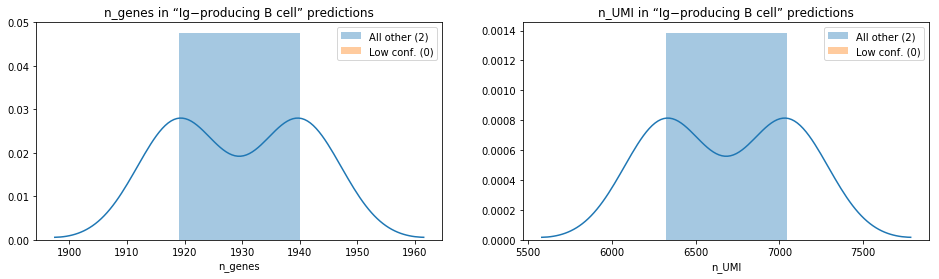

Statistics of predictions for Conventional dendritic cell_H2-M2 high:
count    23.000000
mean      0.916647
std       0.120679
min       0.609404
25%       0.836595
50%       0.989732
75%       0.999202
max       0.999906
Name: Conventional dendritic cell_H2-M2 high, dtype: float64


/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


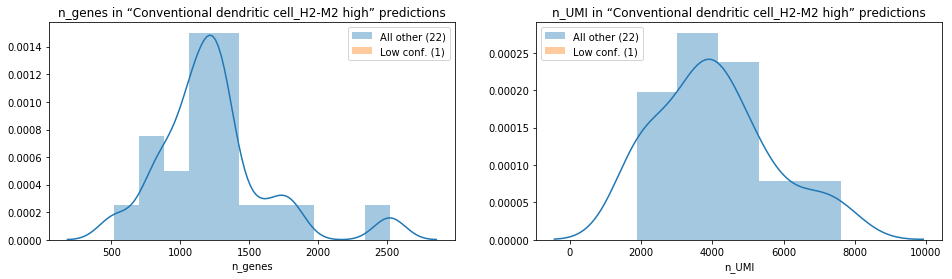

Statistics of predictions for Basophil:
count    1.000000
mean     0.761124
std           NaN
min      0.761124
25%      0.761124
50%      0.761124
75%      0.761124
max      0.761124
Name: Basophil, dtype: float64


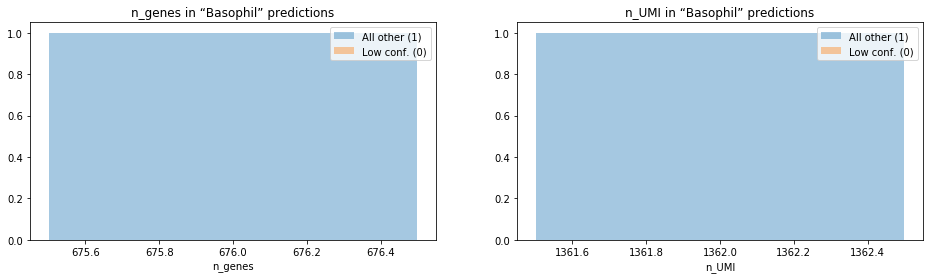

Statistics of predictions for Monocyte progenitor cell:
count    5.000000
mean     0.424385
std      0.144459
min      0.213182
25%      0.379602
50%      0.416899
75%      0.523743
max      0.588498
Name: Monocyte progenitor cell, dtype: float64


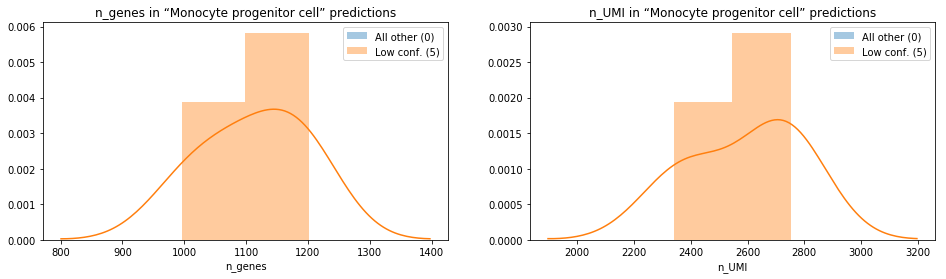

Statistics of predictions for Conventional dendritic cell_Tubb5 high:
count    24.000000
mean      0.755991
std       0.191641
min       0.291337
25%       0.677246
50%       0.819994
75%       0.900046
max       0.962611
Name: Conventional dendritic cell_Tubb5 high, dtype: float64


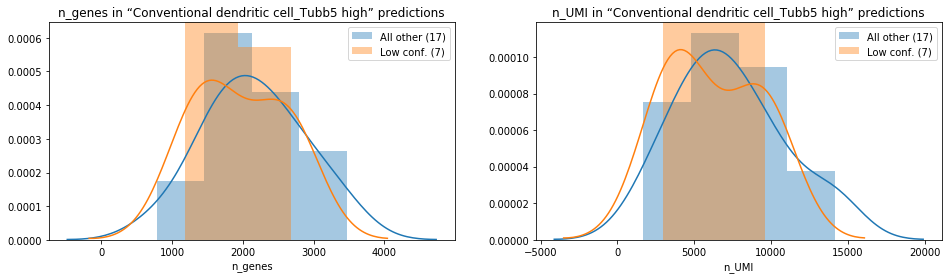

In [170]:
tech_vars = ('n_genes', 'n_UMI')#, 'percent_mito')
for column_idx, column in enumerate(sc01p.columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(tech_vars))
    fig.set_figwidth(16)
    fig.set_figheight(4)
    cell_type = sc01p.loc[preds == column, column]
    print('Statistics of predictions for {}:'.format(column))
    print(cell_type.describe())
    cell_type_idx = cell_type.index
    low_conf_idx = cell_type.index[cell_type < 0.7]
    high_conf_idx = cell_type.index[cell_type >= 0.7]
    for var_idx, var in enumerate(tech_vars):
        ax = axes[var_idx]
        seaborn.distplot(sc01.obs.loc[high_conf_idx, var], 
                         label='All other ({})'.format(len(high_conf_idx)),
                         ax=ax, norm_hist=True,
                        )
        #seaborn.distplot(sc01.obs.loc[high_conf_idx, var], 
        #                 label='High conf. ({})'.format(len(high_conf_idx)),
        #                 ax=ax, norm_hist=True,
        #                )
        seaborn.distplot(sc01.obs.loc[low_conf_idx, var], 
                         label='Low conf. ({})'.format(len(low_conf_idx)),
                         ax=ax, norm_hist=True,
                        )
        ax.legend()
        ax.set_title('{} in “{}” predictions'.format(var, column))
    plt.show()

Text(0.5,0,'Cell type')

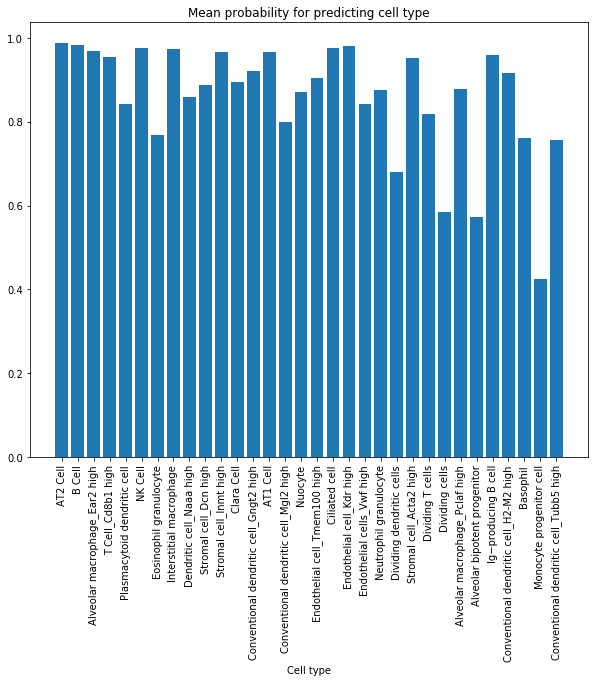

In [166]:
ct_means = []
ct_counts = []
for column in sc01p.columns:
    cell_type = sc01p.loc[preds == column, column]
    ct_means.append(cell_type.mean())
    ct_counts.append(len(cell_type))
ct_counts = pd.Series(ct_counts)
plt.figure(figsize=(10,8))
plt.bar(sc01p.columns, ct_means)
plt.xticks(rotation='vertical')
plt.title('Mean probability for predicting cell type')
plt.xlabel('Cell type')

Text(0.5,0,'Cell type')

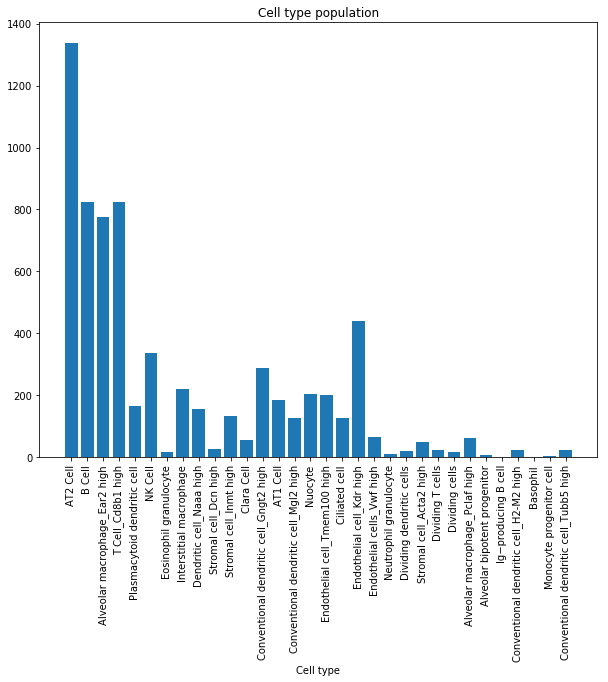

In [168]:
plt.figure(figsize=(10,8))
plt.bar(sc01p.columns, ct_counts)
plt.xticks(rotation='vertical')
plt.title('Cell type population')
plt.xlabel('Cell type')

In [172]:
sc01.X.to

<6763x16265 sparse matrix of type '<class 'numpy.float32'>'
	with 8031790 stored elements in Compressed Sparse Row format>